# MULTI-STATE CLASSIFICATION OF TUMORS FROM CRANIAL IMAGES

# Term project for AMLS_ELEC0134


#  Import libraries and define global variables

In [9]:
# 
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score
%matplotlib inline
import matplotlib.pyplot as mplp
import matplotlib.image as mpimg
from keras.preprocessing import image
from PIL import Image
import cv2
import numpy
import os
import pandas
from sklearn.metrics import confusion_matrix
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

global learning_rate
global training_epochs
global display_accuracy_step
global DropConnectRate
global numSessions

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


# Import Images

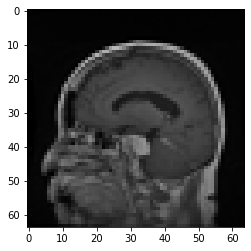

trainingImages dimensionality is  (3000, 64, 64)


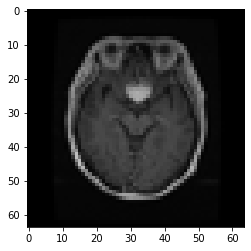

testImages dimensionality is  (200, 64, 64)


In [10]:

#
# Define the resolution size of our images
#target_size=[512,512] # OOM Error
#target_size=[256,256] # max value that runs
#target_size=[128,128]
target_size=[64,64]

#
# load the images
training_images_dir='./trainingDataset/image'
training_images_paths = [os.path.join(training_images_dir,l) for l in os.listdir(training_images_dir)]
training_images = []
#print(training_images_paths)
for img_path in training_images_paths:
    filename=img_path.split('\\')[-1]
    #print('filename=',filename)
    img = image.img_to_array(image.load_img(img_path,target_size=target_size, interpolation='bicubic'))
    imgBW = img[:,:,0]
    #print(img.shape)
    #print(imgBW.shape)
    imgFile = cv2.imread(img_path,0) # for edge detection
    '''# Downres the image
    ratioX = int(len(imgFile)/target_size[0])
    ratioY = int(len(imgFile.T)/target_size[1])
    #print(ratioX,ratioY)
    imgDownres=numpy.zeros([target_size[0],target_size[1]])
    for x in range(target_size[0]):
        for y in range(target_size[1]):
            for i in range (ratioX):
                for j in range(ratioY):
                    imgDownres[x,y] = imgDownres[x,y]+ imgFile[x*ratioX+i, y*ratioY+j]
    imgDownres = imgDownres/(ratioX*ratioY)
    imgDownres = numpy.uint8(imgDownres)
    #imgDownres = imgFile.resize(target_size[0],target_size[1]) # for edge detection
    imgCanny = cv2.Canny(imgDownres,threshold1=10, threshold2=150) # Canny Edge Detection'''
    imgCanny = cv2.Canny(imgFile,threshold1=10, threshold2=150) # Canny Edge Detection
    if (filename=='IMAGE_0000.jpg'):
        mplp.imshow(img/255)
        mplp.show()
        #mplp.imshow(imgBW/255)
        #mplp.show()
        #mplp.imshow(imgCanny/255)
        #mplp.show()
        #mplp.imshow(imgDownres/255)
        #mplp.show()
    training_images.append(imgBW)  #RESTORE RAW DATA IF ALL ELSE FAILS
    #training_images.append(imgCanny)  # for edge detection
    #ret, thresh = cv2.threshold(imgFile,127,255,0) # for contour detection
    #contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # for contour detection
    #training_images.append(contours) # for contour detection
trainingImages=numpy.array(training_images)
print('trainingImages dimensionality is ',trainingImages.shape)

test_images_dir='./testDataset/image'
test_images_paths = [os.path.join(test_images_dir,l) for l in os.listdir(test_images_dir)]
test_images = []
for img_path in test_images_paths:
    filename=img_path.split('\\')[-1]
    #print('filename=',filename)
    img = image.img_to_array(image.load_img(img_path,target_size=target_size, interpolation='bicubic'))
    imgBW = img[:,:,0]
    #print(img.shape)
    #print(imgBW.shape)
    imgFile = cv2.imread(img_path,0)  # for edge detection
    '''# Downres the image
    ratioX = int(len(imgFile)/target_size[0])
    ratioY = int(len(imgFile.T)/target_size[1])
    #print(ratioX,ratioY)
    # Downres the image
    imgDownres=numpy.zeros([target_size[0],target_size[1]])
    for x in range(target_size[0]):
        for y in range(target_size[1]):
            for i in range (ratioX):
                for j in range(ratioY):
                    imgDownres[x,y] = imgDownres[x,y]+ imgFile[x*ratioX+i, y*ratioY+j]
    imgDownres = imgDownres/(ratioX*ratioY)
    imgDownres = numpy.uint8(imgDownres)
    #imgDownres = imgFile.resize(target_size[0],target_size[1]) # for edge detection
    imgCanny = cv2.Canny(imgDownres,threshold1=10, threshold2=150) # Canny Edge Detection'''
    imgCanny = cv2.Canny(imgFile,threshold1=10, threshold2=150) # Canny Edge Detection
    if (filename=='IMAGE_0000.jpg'):
        mplp.imshow(img/255)
        mplp.show()
        #mplp.imshow(imgBW/255)
        #mplp.show()
        #mplp.imshow(imgCanny/255)
        #mplp.show()
        #mplp.imshow(imgDownres/255)
        #mplp.show()
    test_images.append(imgBW) # RESTORE RAW DATA IF ALL ELSE FAILS
    #test_images.append(imgCanny)  # for edge detection
    #ret, thresh = cv2.threshold(imgFile,127,255,0) # for contour detection
    #contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # for contour detection
    #test_images.append(contours) # for contour detection
testImages=numpy.array(test_images)
print('testImages dimensionality is ',testImages.shape)

# Import tumor labels (multistate and binary versions)

In [11]:
#
# Import training labels
#
trainingTumorLabels= pandas.read_csv('./trainingDataset/label.csv')
#print(trainingTumorLabels.shape)
#print(trainingTumorLabels)
trainingTumorLabels=trainingTumorLabels['label']
#print(trainingTumorLabels.shape)
#print(trainingTumorLabels)

trainingGliomaClass = numpy.array([[1,0] if label=='glioma_tumor' else [0,1] for label in trainingTumorLabels])
#print('trainingGliomaClass = ',trainingGliomaClass.T)
trainingMeningiomaClass = numpy.array([[1,0] if label=='meningioma_tumor' else [0,1] for label in trainingTumorLabels])
#prirainingnt('trainingMeningiomaClass =',trainingMeningiomaClass.T)
trainingPituitaryClass = numpy.array([[1,0] if label=='pituitary_tumor' else [0,1] for label in trainingTumorLabels])
#print('trainingPituitaryClass = ',trainingPituitaryClass.T)
trainingAnyTumorClass = numpy.array([[0,1] if label=='no_tumor' else [1,0] for label in trainingTumorLabels])
#print('trainingIsTumorClass = ',trainingIsTumorClass.T)

trainingAllTumorClass = numpy.zeros((4,len(trainingTumorLabels)))                               
trainingAllTumorClass[0] = trainingGliomaClass.T[0]
trainingAllTumorClass[1] = trainingMeningiomaClass.T[0]
trainingAllTumorClass[2] = trainingPituitaryClass.T[0]
trainingAllTumorClass[3] = trainingAnyTumorClass.T[1]
trainingAllTumorClass = trainingAllTumorClass.T
#print('trainingAllTumorClass = \n',trainingAllTumorClass)

#
# Import test labels
#
testTumorLabels= pandas.read_csv('./testDataset/label.csv')
#print(testTumorLabels.shape)
#print(testTumorLabels)
testTumorLabels=testTumorLabels['label']
#print(testTumorLabels.shape)
#print(testTumorLabels)

testGliomaClass = numpy.array([[1,0] if label=='glioma_tumor' else [0,1] for label in testTumorLabels])
#print('testGliomaClass = ',testGliomaClass.T)
testMeningiomaClass = numpy.array([[1,0] if label=='meningioma_tumor' else [0,1] for label in testTumorLabels])
#print('testMeningiomaClass =',testMeningiomaClass.T)
testPituitaryClass = numpy.array([[1,0] if label=='pituitary_tumor' else [0,1] for label in testTumorLabels])
#print('testPituitaryClass = ',testPituitaryClass.T)
testAnyTumorClass = numpy.array([[0,1] if label=='no_tumor' else [1,0] for label in testTumorLabels])
#print('testIsTumorClass = ',testIsTumorClass.T)

testAllTumorClass = numpy.zeros((4,len(testTumorLabels)))                               
testAllTumorClass[0] = testGliomaClass.T[0]
testAllTumorClass[1] = testMeningiomaClass.T[0]
testAllTumorClass[2] = testPituitaryClass.T[0]
testAllTumorClass[3] = testAnyTumorClass.T[1]
testAllTumorClass = testAllTumorClass.T
#print('testAllTumorClass = \n',testAllTumorClass)


# Define and run SVM on the binary classification

In [12]:
def SVM(x_train,y_train, x_test):
    #model= SVC(kernel='linear')  # kernel = linear, poly, rbf
    model= SVC(kernel='poly')  # kernel = linear, poly, rbf
    #model= SVC(kernel='rbf')  # kernel = linear, poly, rbf
    #model= svm.LinearSVC()  # linear model
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return y_pred

# Flatten each of the training images to be one-dimensional
trainingImagesFlat = numpy.zeros([trainingImages.shape[0],trainingImages.shape[1]*trainingImages.shape[2]])
for i in range(trainingImages.shape[0]):
    image = trainingImages[0]
    trainingImagesFlat[i]=image.flatten()
# Flatten each of the test images to be one-dimensional
testImagesFlat = numpy.zeros([testImages.shape[0],testImages.shape[1]*testImages.shape[2]])
for i in range(testImages.shape[0]):
    image = testImages[0]
    testImagesFlat[i]=image.flatten()
    
print('SVM results for binary classification')
print('Image_size = ',target_size)
predictionsAnyTumor = SVM(trainingImagesFlat,trainingAnyTumorClass[:,0],testImagesFlat)
print('Accuracy =',100*accuracy_score(testAnyTumorClass[:,0],predictionsAnyTumor),'%')
print('\nActual values in X (left column= positive/ right column = negative)')
print('Predicted values in Y (top row = positive/ bottom row = negative)')
cm=confusion_matrix(1-predictionsAnyTumor,1-testAnyTumorClass[:,0])
print(cm)
print('\nPredictions')
print(predictionsAnyTumor)


SVM results for binary classification
Image_size =  [64, 64]
Accuracy = 81.5 %

Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[163  37]
 [  0   0]]

Predictions
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Define an MLP with variable number of output states and 1-4 hidden layers 
# The input is the number of neurons in each layer

In [12]:

def allocate_multidimensional_weights_and_biases(neurons_hidden, numOutputClasses):
    print('Image resolution =',target_size)
    
    # define number of hidden layers ..
    num_layers = len(neurons_hidden)

    # inputs placeholders
    X = tf.placeholder("float", [None, target_size[0],target_size[1]]) # image resolution defined by target_size
    Y = tf.placeholder("float", [None, numOutputClasses])  # number of output classes
    
    # flatten image features into one vector (i.e. reshape image feature matrix into a vector)
    images_flat = tf.layers.flatten(X)  # this generates a deprecation warning
    #images_flat = tf.keras.layers.Flatten(X) # this doesn't work
    
    # weights and biases are initialized from a normal distribution with a specified standard devation stddev
    stddev = 0.01
    
    # define placeholders for weights and biases in the graph
    if num_layers==0:
        weights = {
            'out': tf.Variable(tf.random_normal([target_size[0]*target_size[1], numOutputClasses], stddev=stddev))
        }
        biases = {
            'out': tf.Variable(tf.random_normal([numOutputClasses], stddev=stddev))
        }
    if num_layers==1:
        weights = {
            'hidden_layer1': tf.Variable(tf.random_normal([target_size[0]*target_size[1], neurons_hidden[0]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([neurons_hidden[num_layers-1], numOutputClasses], stddev=stddev))
        }
        biases = {
            'bias_layer1': tf.Variable(tf.random_normal([neurons_hidden[0]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([numOutputClasses], stddev=stddev))
        }
        
    if num_layers==2:
        weights = {
            'hidden_layer1': tf.Variable(tf.random_normal([target_size[0]*target_size[1], neurons_hidden[0]], stddev=stddev)),
            'hidden_layer2': tf.Variable(tf.random_normal([neurons_hidden[0], neurons_hidden[1]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([neurons_hidden[num_layers-1], numOutputClasses], stddev=stddev))
        }
        biases = {
            'bias_layer1': tf.Variable(tf.random_normal([neurons_hidden[0]], stddev=stddev)),
            'bias_layer2': tf.Variable(tf.random_normal([neurons_hidden[1]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([numOutputClasses], stddev=stddev))
        }
              
    if num_layers==3:
        weights = {
            'hidden_layer1': tf.Variable(tf.random_normal([target_size[0]*target_size[1], neurons_hidden[0]], stddev=stddev)),
            'hidden_layer2': tf.Variable(tf.random_normal([neurons_hidden[0], neurons_hidden[1]], stddev=stddev)),
            'hidden_layer3': tf.Variable(tf.random_normal([neurons_hidden[1], neurons_hidden[2]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([neurons_hidden[num_layers-1], numOutputClasses], stddev=stddev))
        }
        biases = {
            'bias_layer1': tf.Variable(tf.random_normal([neurons_hidden[0]], stddev=stddev)),
            'bias_layer2': tf.Variable(tf.random_normal([neurons_hidden[1]], stddev=stddev)),
            'bias_layer3': tf.Variable(tf.random_normal([neurons_hidden[2]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([numOutputClasses], stddev=stddev))
        }
           
    if num_layers==4:
        weights = {
            'hidden_layer1': tf.Variable(tf.random_normal([target_size[0]*target_size[1], neurons_hidden[0]], stddev=stddev)),
            'hidden_layer2': tf.Variable(tf.random_normal([neurons_hidden[0], neurons_hidden[1]], stddev=stddev)),
            'hidden_layer3': tf.Variable(tf.random_normal([neurons_hidden[1], neurons_hidden[2]], stddev=stddev)),
            'hidden_layer4': tf.Variable(tf.random_normal([neurons_hidden[2], neurons_hidden[3]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([neurons_hidden[num_layers-1], numOutputClasses], stddev=stddev))
        }
        biases = {
            'bias_layer1': tf.Variable(tf.random_normal([neurons_hidden[0]], stddev=stddev)),
            'bias_layer2': tf.Variable(tf.random_normal([neurons_hidden[1]], stddev=stddev)),
            'bias_layer3': tf.Variable(tf.random_normal([neurons_hidden[2]], stddev=stddev)),
            'bias_layer4': tf.Variable(tf.random_normal([neurons_hidden[3]], stddev=stddev)),
            'out': tf.Variable(tf.random_normal([numOutputClasses], stddev=stddev))
        }
    
    return weights, biases, X, Y, images_flat
    

In [13]:
# Create model
def multidimensional_multilayer_perceptron_with_dropconnect(neurons_hidden,numOutputClasses):
        
    num_layers = len(neurons_hidden) 
    weights, biases, X, Y, images_flat = allocate_multidimensional_weights_and_biases(neurons_hidden=neurons_hidden, numOutputClasses=numOutputClasses)
    
    DropConnectKeepRate = 1.0 - DropConnectRate
        
    # Hidden fully connected layer 1
    if (num_layers >=1):
        dropConnect = tf.nn.dropout(weights['hidden_layer1'], DropConnectKeepRate) * DropConnectKeepRate
        layer_1 = tf.add(tf.matmul(images_flat, dropConnect), biases['bias_layer1'])
        layer_1 = tf.sigmoid(layer_1)
        layer_final = layer_1

    # Hidden fully connected layer 2
    if (num_layers>=2):
        dropConnect = tf.nn.dropout(weights['hidden_layer2'], DropConnectKeepRate) * DropConnectKeepRate
        layer_2 = tf.add(tf.matmul(layer_1, dropConnect), biases['bias_layer2'])
        layer_2 = tf.sigmoid(layer_2)
        layer_final = layer_2

    # Hidden fully connected layer 3
    if (num_layers>=3):
        dropConnect = tf.nn.dropout(weights['hidden_layer3'], DropConnectKeepRate) * DropConnectKeepRate
        layer_3 = tf.add(tf.matmul(layer_2, dropConnect), biases['bias_layer3'])
        layer_3 = tf.sigmoid(layer_3)
        layer_final = layer_3

    # Hidden fully connected layer 4
    if (num_layers>=4):
        dropConnect = tf.nn.dropout(weights['hidden_layer4'], DropConnectKeepRate) * DropConnectKeepRate
        layer_4 = tf.add(tf.matmul(layer_3, dropConnect), biases['bias_layer4'])
        layer_4 = tf.sigmoid(layer_4)
        layer_final = layer_4                     
    
    # Output fully connected layer
    dropConnect = tf.nn.dropout(weights['out'], DropConnectKeepRate) * DropConnectKeepRate
    out_layer = tf.matmul(layer_final, dropConnect) + biases['out']

    return out_layer, X, Y



In [15]:
#
# Try L1 regularization?
model_l2 = tf.keras.models.Sequential([
    # layer 1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 2
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 3
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 4
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True , kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # layer 5
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True,  kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    
    # layer 6
    tf.keras.layers.Dense(3, activation='softmax', use_bias=True)
    
])

In [16]:
#
# Try Bagging?
#clf = BaggingClassifier(mlp, n_estimators=8)
#clf.fit(X_train,y_train)

In [14]:
def print_multidimensional_confusion_matrix(predictionClasses, actualClasses,labels):
   #print(testClasses.T)
   #print(predictions_onehot.T)
   print('\nConfusion Matrix')
   if (len(actualClasses.T)==2):
       print('Actual values in X (left column= positive/ right column = negative)')
       print('Predicted values in Y (top row = positive/ bottom row = negative)')
   else:
       print('Actual values in X [left column=Glioma Tumor, next=Meningioma Tumor, next=Pituitary Tumor, right column=healthy (no tumor)]')
       print('Predicted values in Y [top row =Glioma Tumor, next=Meningioma Tumor, next=Pituitary Tumor, bottom row=healthy (no tumor)]')
   
   #confusionMatrix = confusion_matrix(predictionClasses.T[0],actualClasses.T[0])
   confusionMatrix = numpy.zeros((len(predictionClasses[0]), len(actualClasses[0])),dtype=int)
   for (i, prediction) in enumerate(predictionClasses):
        prediction = list(predictionClasses[i])
        actual = list(actualClasses[i])
        column = actual.index(max(actual))
        row = prediction.index(max(prediction))
        confusionMatrix[row][column] = confusionMatrix[row][column]+1 
   print(confusionMatrix,'\n')
 
   inputNumbers = numpy.sum(confusionMatrix, axis=0)
   for i in range(len(inputNumbers)):
    print(inputNumbers[i],'cases of',labels[i],':',round(100*confusionMatrix[i,i]/inputNumbers[i],2),'% chance of correct prediction')
    
   print('')
   outputNumbers = numpy.sum(confusionMatrix, axis=1)
   for i in range(len(outputNumbers)):
    print(outputNumbers[i],'predictions of',labels[i],':',round(100*confusionMatrix[i,i]/outputNumbers[i],2),'% chance of correct prediction')
   
   correctPredictions= 0
   for i in range(len(confusionMatrix)):
        correctPredictions= correctPredictions+confusionMatrix[i][i]
   totalPredictions = numpy.sum(confusionMatrix)
   print('\nOverall accuracy = ',round(100*correctPredictions/totalPredictions,2),'%')
   return

In [15]:
#
# MLP calculates all four possible states at once
# MLP can be called with DropConnect
# MLP can be called with different target label sets
#
def initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingClasses, testImages, testClasses, neurons_hidden, labelType):
  # display training accuracy every ..
  #display_accuracy_step = 50

  numOutputClasses = len(trainingClasses.T)
  print('numOutputClasses = ',numOutputClasses)
  print('neurons_hidden =',neurons_hidden)
  if (len(testClasses.T)==2):
        labels = ['a '+labelType+' tumor', 'no '+labelType+' tumor']
  else:
        labels=['Glioma','Meningioma','Pituitary','Healthy']
  logits, X, Y = multidimensional_multilayer_perceptron_with_dropconnect(neurons_hidden=neurons_hidden,numOutputClasses=numOutputClasses)

  # define loss and optimizer
  loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

  # define training graph operation
  train_op = optimizer.minimize(loss_op)

  # graph operation to initialize all variables
  init_op = tf.global_variables_initializer()
    
  with tf.Session() as sess:
    accuracy_eval = numpy.zeros(numSessions)
    
    for session in range(numSessions):
        # run graph weights/biases initialization op
        sess.run(init_op)
        print('\nSession ',session+1)
        # begin training loop ..
        for epoch in range(training_epochs):
            # complete code below
            # run optimization operation (backprop) and cost operation (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: trainingImages,
                                                               Y: trainingClasses})

            # Display logs per epoch step
            #print("Epoch:", '%04d' % (epoch + 1), "cost={:.9f}".format(cost))
                
            if epoch % display_accuracy_step == 0:
                print("Epoch:", '%04d' % (epoch + 1), "cost={:.9f}".format(cost))
                pred = tf.nn.softmax(logits)  # Apply softmax to logits
                correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

                # calculate training accuracy
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                print("Training Accuracy: {:.4f}".format(accuracy.eval({X: training_images, Y: trainingClasses})))

        print('Session ',session+1," Optimization Finished!")

        # -- Define and run test operation -- #
        
        # apply softmax to output logits
        pred = tf.nn.softmax(logits)
        
        #  derive inferred classes as the class with the top value in the output density function
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        
        # calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            
        # run test accuracy operation ..
        accuracy_eval[session] = accuracy.eval({X: testImages, Y: testClasses})
        print('Session ',session+1," Test Accuracy:", round(100*accuracy_eval[session],2),'%')
        
        predictions = pred.eval(feed_dict = {X:testImages})
        #print(predictions)
        #predictions_onehot = predictions.copy()
        predictions_onehot = numpy.zeros((len(predictions),len(predictions.T)))
        for i, prediction in enumerate(predictions):
            #print(i,'prediction = ', prediction)
            prediction = list(prediction)
            maxPrediction = max(prediction)
            maxPosition = prediction.index(max(prediction)) # Which state has the maximum likelihood?  (First position in case of a tie.)
            predictions_onehot[i,maxPosition] = 1
            #print(predictions_onehot[i])
        #print(predictions_onehot)
        print_multidimensional_confusion_matrix(predictions_onehot, testClasses, labels=labels)
        
    print('\nMean Test Accuracy = ',round(100*numpy.mean(accuracy_eval),2),'%\n')
    return(predictions_onehot, predictions)

# Apply the MLP to the binary classification

In [19]:
# Vary the number of neurons and number of layers
learning_rate = 1e-5
training_epochs = 500
display_accuracy_step = 10
neurons_hidden=[2048]
DropConnectRate = 0.0
numSessions=5

# Vary the number of neurons and number of layers
for neurons_hidden in ([2048],[2048,2048],[2048,2048,2048],[2048,2048,2048,2048],[512],[1024],[4096]):
    predictions_onehot, predictionsAnyTumor = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingAnyTumorClass, testImages, testAnyTumorClass, neurons_hidden=neurons_hidden, labelType='(non-specified) ')


numOutputClasses =  2
neurons_hidden = [2048]
Image resolution = [64, 64]
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Session  1
Training Accuracy: 0.1513
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8493
Training Accuracy: 0.8493
Training Accuracy: 0.8507
Training Accuracy: 0.8507
Training Accuracy: 0.8520
Training Accuracy: 0.8550
Training Accuracy: 0.8580
Training Accuracy: 0.8600
Training Accuracy: 0.8657
Training Accuracy: 0.8680
Training Accuracy: 0.8727
Training Accuracy: 0.8810
Training

Training Accuracy: 0.9977
Training Accuracy: 0.9973
Training Accuracy: 0.9970
Training Accuracy: 0.9970
Session  4  Optimization Finished!
Session  4  Test Accuracy: 92.5 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[163  15]
 [  0  22]] 

163 cases of a (non-specified)  tumor : 100.0 % chance of correct prediction
37 cases of no (non-specified)  tumor : 59.46 % chance of correct prediction

178 predictions of a (non-specified)  tumor : 91.57 % chance of correct prediction
22 predictions of no (non-specified)  tumor : 100.0 % chance of correct prediction

Overall accuracy =  92.5 %

Session  5
Training Accuracy: 0.7680
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8493
Training Accuracy: 0.8507
Training Accuracy: 0.8567
Training Accuracy: 0.8617
Training Accuracy: 0.8667
Tra

Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8523
Training Accuracy: 0.8637
Training Accuracy: 0.8943
Training Accuracy: 0.9183
Training Accuracy: 0.9343
Training Accuracy: 0.9503
Training Accuracy: 0.9620
Training Accuracy: 0.9743
Training Accuracy: 0.9783
Training Accuracy: 0.9823
Training Accuracy: 0.9847
Training Accuracy: 0.9860
Training Accuracy: 0.9880
Training Accuracy: 0.9883
Training Accuracy: 0.9883
Training Accuracy: 0.9887
Training Accuracy: 0.9880
Training Accuracy: 0.9877
Training Accuracy: 0.9880
Training Accuracy: 0.9883
Training Accuracy: 0.9890
Training Acc

Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8540
Training Accuracy: 0.8780
Training Accuracy: 0.9203
Training Accuracy: 0.9573
Training Accuracy: 0.9763
Training Accuracy: 0.9793
Training Accuracy: 0.9830
Training Accuracy: 0.9833
Training Accuracy: 0.9837
Training Accuracy: 0.9843
Training Accuracy: 0.9840
Training Accuracy: 0.9847
Training Accuracy: 0.9857
Training Accuracy: 0.9857
Training Accuracy: 0.9857
Training Accuracy: 0.9857
Training Accuracy: 0.9873
Training Accuracy: 0.9873
Training Accuracy: 0.9880
Training Accuracy: 0.9890
Training Accuracy: 0.9897
Training Accuracy: 0.9897
Training Accuracy: 0.9897
Session  3  Optimization Finished!
Session  3  Test Accuracy: 92.5 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted val

Training Accuracy: 0.9797
Training Accuracy: 0.9827
Training Accuracy: 0.9833
Training Accuracy: 0.9833
Training Accuracy: 0.9840
Training Accuracy: 0.9847
Training Accuracy: 0.9850
Training Accuracy: 0.9850
Training Accuracy: 0.9857
Training Accuracy: 0.9860
Training Accuracy: 0.9870
Training Accuracy: 0.9873
Training Accuracy: 0.9873
Training Accuracy: 0.9880
Session  2  Optimization Finished!
Session  2  Test Accuracy: 92.0 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[161  14]
 [  2  23]] 

163 cases of a (non-specified)  tumor : 98.77 % chance of correct prediction
37 cases of no (non-specified)  tumor : 62.16 % chance of correct prediction

175 predictions of a (non-specified)  tumor : 92.0 % chance of correct prediction
25 predictions of no (non-specified)  tumor : 92.0 % chance of correct prediction

Overall accuracy =  92.0 %

Session  3
Training Accuracy: 0.1513
Train

C:\Users\randy\anaconda3\envs\Python3pt6\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8493
Training Accuracy: 0.8493
Training Accuracy: 0.8497
Training Accuracy: 0.8497
Training Acc

Training Accuracy: 0.8510
Training Accuracy: 0.8523
Training Accuracy: 0.8537
Training Accuracy: 0.8563
Training Accuracy: 0.8610
Training Accuracy: 0.8613
Training Accuracy: 0.8637
Training Accuracy: 0.8683
Training Accuracy: 0.8753
Training Accuracy: 0.8770
Training Accuracy: 0.8860
Training Accuracy: 0.9007
Training Accuracy: 0.9073
Training Accuracy: 0.9100
Training Accuracy: 0.9133
Training Accuracy: 0.9193
Training Accuracy: 0.9257
Training Accuracy: 0.9340
Training Accuracy: 0.9383
Training Accuracy: 0.9400
Training Accuracy: 0.9490
Training Accuracy: 0.9543
Training Accuracy: 0.9577
Training Accuracy: 0.9613
Training Accuracy: 0.9670
Training Accuracy: 0.9720
Training Accuracy: 0.9740
Training Accuracy: 0.9767
Training Accuracy: 0.9773
Training Accuracy: 0.9783
Training Accuracy: 0.9797
Session  1  Optimization Finished!
Session  1  Test Accuracy: 91.5 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positi

Training Accuracy: 0.9813
Training Accuracy: 0.9830
Training Accuracy: 0.9843
Training Accuracy: 0.9857
Training Accuracy: 0.9867
Training Accuracy: 0.9880
Training Accuracy: 0.9887
Training Accuracy: 0.9893
Training Accuracy: 0.9897
Session  5  Optimization Finished!
Session  5  Test Accuracy: 92.0 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[163  16]
 [  0  21]] 

163 cases of a (non-specified)  tumor : 100.0 % chance of correct prediction
37 cases of no (non-specified)  tumor : 56.76 % chance of correct prediction

179 predictions of a (non-specified)  tumor : 91.06 % chance of correct prediction
21 predictions of no (non-specified)  tumor : 100.0 % chance of correct prediction

Overall accuracy =  92.0 %

Mean Test Accuracy =  91.4 %

numOutputClasses =  2
neurons_hidden = [4096]
Image resolution = [64, 64]

Session  1
Training Accuracy: 0.8467
Training Accuracy: 0.8487
Tr

Training Accuracy: 0.8450
Training Accuracy: 0.8487
Training Accuracy: 0.8493
Training Accuracy: 0.8660
Training Accuracy: 0.8733
Training Accuracy: 0.8910
Training Accuracy: 0.9113
Training Accuracy: 0.9237
Training Accuracy: 0.9417
Training Accuracy: 0.9523
Training Accuracy: 0.9630
Training Accuracy: 0.9687
Training Accuracy: 0.9747
Training Accuracy: 0.9817
Training Accuracy: 0.9847
Training Accuracy: 0.9873
Training Accuracy: 0.9903
Training Accuracy: 0.9923
Training Accuracy: 0.9940
Training Accuracy: 0.9963
Training Accuracy: 0.9970
Training Accuracy: 0.9977
Training Accuracy: 0.9987
Training Accuracy: 0.9987
Training Accuracy: 0.9987
Training Accuracy: 0.9987
Training Accuracy: 0.9987
Training Accuracy: 0.9993
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 0.9997
Training Accuracy: 1.0000
Training Acc

Training Accuracy: 0.8487
Training Accuracy: 0.8493
Training Accuracy: 0.8500
Training Accuracy: 0.8593
Training Accuracy: 0.8710
Training Accuracy: 0.8980
Training Accuracy: 0.9190
Training Accuracy: 0.9393
Training Accuracy: 0.9520
Training Accuracy: 0.9593
Training Accuracy: 0.9720
Training Accuracy: 0.9773
Training Accuracy: 0.9797
Training Accuracy: 0.9823
Training Accuracy: 0.9850
Training Accuracy: 0.9857
Training Accuracy: 0.9880
Training Accuracy: 0.9893
Training Accuracy: 0.9900
Training Accuracy: 0.9903
Training Accuracy: 0.9910
Training Accuracy: 0.9913
Training Accuracy: 0.9910
Training Accuracy: 0.9913
Training Accuracy: 0.9907
Training Accuracy: 0.9903
Training Accuracy: 0.9910
Training Accuracy: 0.9907
Training Accuracy: 0.9907
Training Accuracy: 0.9910
Training Accuracy: 0.9910
Training Accuracy: 0.9913
Session  4  Optimization Finished!
Session  4  Test Accuracy: 92.5 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted val

Training Accuracy: 0.9213
Training Accuracy: 0.9240
Training Accuracy: 0.9280
Training Accuracy: 0.9240
Training Accuracy: 0.9373
Training Accuracy: 0.9450
Training Accuracy: 0.9437
Training Accuracy: 0.9550
Training Accuracy: 0.9480
Training Accuracy: 0.9567
Training Accuracy: 0.9553
Training Accuracy: 0.9580
Training Accuracy: 0.9617
Training Accuracy: 0.9570
Session  3  Optimization Finished!
Session  3  Test Accuracy: 92.5 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[162  12]
 [  1  25]] 

163 cases of a (non-specified)  tumor : 99.39 % chance of correct prediction
37 cases of no (non-specified)  tumor : 67.57 % chance of correct prediction

174 predictions of a (non-specified)  tumor : 93.1 % chance of correct prediction
26 predictions of no (non-specified)  tumor : 96.15 % chance of correct prediction

Overall accuracy =  93.5 %

Session  4
Training Accuracy: 0.8487
Trai

Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8493
Training Accuracy: 0.8473
Training Accuracy: 0.8493
Training Accuracy: 0.8533
Training Accuracy: 0.8537
Training Accuracy: 0.8517
Training Accuracy: 0.8517
Training Accuracy: 0.8597
Training Accuracy: 0.8650
Training Accuracy: 0.8697
Training Accuracy: 0.8887
Training Accuracy: 0.8727
Training Accuracy: 0.9000
Training Accuracy: 0.8910
Training Accuracy: 0.9000
Training Accuracy: 0.8757
Training Accuracy: 0.9043
Training Acc

Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8477
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8483
Training Accuracy: 0.8480
Training Accuracy: 0.8477
Training Accuracy: 0.8473
Training Accuracy: 0.8483
Training Accuracy: 0.8560
Session  2  Optimization Finished!
Session  2  Test Accuracy: 81.5 %

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted val

C:\Users\randy\anaconda3\envs\Python3pt6\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8467
Training Accuracy: 0.8473
Training Accuracy: 0.8480
Training Accuracy: 0.8477
Training Accuracy: 0.8477
Training Accuracy: 0.8480
Training Accuracy: 0.8473
Training Acc

C:\Users\randy\anaconda3\envs\Python3pt6\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


Training Accuracy: 0.1513
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Accuracy: 0.8487
Training Acc

In [23]:
#Vary the DropConnect Rate

learning_rate = 1e-5
training_epochs = 1000
display_accuracy_step = 10
neurons_hidden = [2048,2048]
for DropConnectRate in (0.005, 0.01, 0.03):
        print('\nDropConnectRate =',DropConnectRate)
        predictions_onehot, predictionsAnyTumor = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingAnyTumorClass, testImages, testAnyTumorClass, neurons_hidden=neurons_hidden, labelType='(non-specified) ')

    


DropConnectRate = 0.005
numOutputClasses =  2
neurons_hidden = [2048, 2048]
Image resolution = [64, 64]

Session  1
Epoch: 0001 cost=0.594988048
Training Accuracy: 0.8487
Epoch: 0011 cost=0.431473434
Training Accuracy: 0.8487
Epoch: 0021 cost=0.426549286
Training Accuracy: 0.8487
Epoch: 0031 cost=0.420339644
Training Accuracy: 0.8487
Epoch: 0041 cost=0.413256198
Training Accuracy: 0.8487
Epoch: 0051 cost=0.408467293
Training Accuracy: 0.8487
Epoch: 0061 cost=0.402098268
Training Accuracy: 0.8487
Epoch: 0071 cost=0.395277619
Training Accuracy: 0.8487
Epoch: 0081 cost=0.387532383
Training Accuracy: 0.8487
Epoch: 0091 cost=0.378253698
Training Accuracy: 0.8487
Epoch: 0101 cost=0.367362499
Training Accuracy: 0.8487
Epoch: 0111 cost=0.356195360
Training Accuracy: 0.8487
Epoch: 0121 cost=0.343829453
Training Accuracy: 0.8487
Epoch: 0131 cost=0.330767423
Training Accuracy: 0.8487
Epoch: 0141 cost=0.316878349
Training Accuracy: 0.8487
Epoch: 0151 cost=0.303110421
Training Accuracy: 0.8493
Epo

Epoch: 0361 cost=0.098515727
Training Accuracy: 0.9777
Epoch: 0371 cost=0.093838245
Training Accuracy: 0.9787
Epoch: 0381 cost=0.090600707
Training Accuracy: 0.9797
Epoch: 0391 cost=0.086558692
Training Accuracy: 0.9817
Epoch: 0401 cost=0.082779616
Training Accuracy: 0.9820
Epoch: 0411 cost=0.078525789
Training Accuracy: 0.9833
Epoch: 0421 cost=0.074194923
Training Accuracy: 0.9830
Epoch: 0431 cost=0.071772344
Training Accuracy: 0.9837
Epoch: 0441 cost=0.068601705
Training Accuracy: 0.9857
Epoch: 0451 cost=0.065430686
Training Accuracy: 0.9850
Epoch: 0461 cost=0.062195562
Training Accuracy: 0.9870
Epoch: 0471 cost=0.060713820
Training Accuracy: 0.9880
Epoch: 0481 cost=0.057315268
Training Accuracy: 0.9880
Epoch: 0491 cost=0.054843400
Training Accuracy: 0.9887
Epoch: 0501 cost=0.052586470
Training Accuracy: 0.9917
Epoch: 0511 cost=0.051012058
Training Accuracy: 0.9907
Epoch: 0521 cost=0.048827134
Training Accuracy: 0.9913
Epoch: 0531 cost=0.046513081
Training Accuracy: 0.9927
Epoch: 054

Epoch: 0741 cost=0.033063374
Training Accuracy: 0.9957
Epoch: 0751 cost=0.032752834
Training Accuracy: 0.9957
Epoch: 0761 cost=0.031547334
Training Accuracy: 0.9957
Epoch: 0771 cost=0.030907677
Training Accuracy: 0.9957
Epoch: 0781 cost=0.030082071
Training Accuracy: 0.9957
Epoch: 0791 cost=0.029039683
Training Accuracy: 0.9960
Epoch: 0801 cost=0.028477699
Training Accuracy: 0.9960
Epoch: 0811 cost=0.027053053
Training Accuracy: 0.9967
Epoch: 0821 cost=0.026893046
Training Accuracy: 0.9967
Epoch: 0831 cost=0.025506495
Training Accuracy: 0.9967
Epoch: 0841 cost=0.024948815
Training Accuracy: 0.9967
Epoch: 0851 cost=0.024057265
Training Accuracy: 0.9970
Epoch: 0861 cost=0.023535207
Training Accuracy: 0.9973
Epoch: 0871 cost=0.023135563
Training Accuracy: 0.9970
Epoch: 0881 cost=0.021966580
Training Accuracy: 0.9980
Epoch: 0891 cost=0.021929234
Training Accuracy: 0.9980
Epoch: 0901 cost=0.020823160
Training Accuracy: 0.9980
Epoch: 0911 cost=0.020617187
Training Accuracy: 0.9983
Epoch: 092

Epoch: 0011 cost=0.448444456
Training Accuracy: 0.8487
Epoch: 0021 cost=0.426086664
Training Accuracy: 0.8487
Epoch: 0031 cost=0.424845546
Training Accuracy: 0.8487
Epoch: 0041 cost=0.418052644
Training Accuracy: 0.8487
Epoch: 0051 cost=0.413592368
Training Accuracy: 0.8487
Epoch: 0061 cost=0.409272164
Training Accuracy: 0.8487
Epoch: 0071 cost=0.403999239
Training Accuracy: 0.8487
Epoch: 0081 cost=0.398064375
Training Accuracy: 0.8487
Epoch: 0091 cost=0.391599029
Training Accuracy: 0.8487
Epoch: 0101 cost=0.384293705
Training Accuracy: 0.8487
Epoch: 0111 cost=0.376057446
Training Accuracy: 0.8487
Epoch: 0121 cost=0.365959972
Training Accuracy: 0.8487
Epoch: 0131 cost=0.355957776
Training Accuracy: 0.8487
Epoch: 0141 cost=0.345336109
Training Accuracy: 0.8487
Epoch: 0151 cost=0.335137844
Training Accuracy: 0.8487
Epoch: 0161 cost=0.321790636
Training Accuracy: 0.8487
Epoch: 0171 cost=0.311066419
Training Accuracy: 0.8493
Epoch: 0181 cost=0.298210055
Training Accuracy: 0.8493
Epoch: 019

Training Accuracy: 0.9587
Epoch: 0371 cost=0.138950557
Training Accuracy: 0.9603
Epoch: 0381 cost=0.132141680
Training Accuracy: 0.9613
Epoch: 0391 cost=0.126823634
Training Accuracy: 0.9623
Epoch: 0401 cost=0.122144043
Training Accuracy: 0.9710
Epoch: 0411 cost=0.119266659
Training Accuracy: 0.9713
Epoch: 0421 cost=0.111071348
Training Accuracy: 0.9713
Epoch: 0431 cost=0.108125821
Training Accuracy: 0.9730
Epoch: 0441 cost=0.104447588
Training Accuracy: 0.9747
Epoch: 0451 cost=0.100756533
Training Accuracy: 0.9753
Epoch: 0461 cost=0.096027486
Training Accuracy: 0.9770
Epoch: 0471 cost=0.093443312
Training Accuracy: 0.9780
Epoch: 0481 cost=0.089266196
Training Accuracy: 0.9813
Epoch: 0491 cost=0.085646518
Training Accuracy: 0.9817
Epoch: 0501 cost=0.082745828
Training Accuracy: 0.9823
Epoch: 0511 cost=0.078816272
Training Accuracy: 0.9827
Epoch: 0521 cost=0.076042719
Training Accuracy: 0.9817
Epoch: 0531 cost=0.073218219
Training Accuracy: 0.9847
Epoch: 0541 cost=0.069848798
Training A

Training Accuracy: 0.9987
Epoch: 0751 cost=0.016200937
Training Accuracy: 0.9987
Epoch: 0761 cost=0.015702367
Training Accuracy: 0.9987
Epoch: 0771 cost=0.015229159
Training Accuracy: 0.9990
Epoch: 0781 cost=0.014628159
Training Accuracy: 0.9990
Epoch: 0791 cost=0.014446196
Training Accuracy: 0.9990
Epoch: 0801 cost=0.013826243
Training Accuracy: 0.9993
Epoch: 0811 cost=0.013195731
Training Accuracy: 0.9993
Epoch: 0821 cost=0.012883009
Training Accuracy: 0.9993
Epoch: 0831 cost=0.012829787
Training Accuracy: 0.9997
Epoch: 0841 cost=0.012178225
Training Accuracy: 0.9997
Epoch: 0851 cost=0.011723734
Training Accuracy: 0.9997
Epoch: 0861 cost=0.011102774
Training Accuracy: 0.9997
Epoch: 0871 cost=0.010836730
Training Accuracy: 0.9997
Epoch: 0881 cost=0.010679817
Training Accuracy: 0.9997
Epoch: 0891 cost=0.010113784
Training Accuracy: 0.9997
Epoch: 0901 cost=0.010023457
Training Accuracy: 0.9997
Epoch: 0911 cost=0.009830455
Training Accuracy: 0.9997
Epoch: 0921 cost=0.009360107
Training A

Training Accuracy: 0.8487
Epoch: 0021 cost=0.427684069
Training Accuracy: 0.8487
Epoch: 0031 cost=0.419008106
Training Accuracy: 0.8487
Epoch: 0041 cost=0.413035780
Training Accuracy: 0.8487
Epoch: 0051 cost=0.408174813
Training Accuracy: 0.8487
Epoch: 0061 cost=0.402229697
Training Accuracy: 0.8487
Epoch: 0071 cost=0.395663857
Training Accuracy: 0.8487
Epoch: 0081 cost=0.387442559
Training Accuracy: 0.8487
Epoch: 0091 cost=0.378360629
Training Accuracy: 0.8487
Epoch: 0101 cost=0.367207557
Training Accuracy: 0.8487
Epoch: 0111 cost=0.355157316
Training Accuracy: 0.8487
Epoch: 0121 cost=0.342300862
Training Accuracy: 0.8487
Epoch: 0131 cost=0.329595685
Training Accuracy: 0.8487
Epoch: 0141 cost=0.313826770
Training Accuracy: 0.8487
Epoch: 0151 cost=0.300317287
Training Accuracy: 0.8500
Epoch: 0161 cost=0.285516024
Training Accuracy: 0.8507
Epoch: 0171 cost=0.271767855
Training Accuracy: 0.8590
Epoch: 0181 cost=0.259433061
Training Accuracy: 0.8707
Epoch: 0191 cost=0.245600000
Training A

Training Accuracy: 0.9500
Epoch: 0401 cost=0.149817660
Training Accuracy: 0.9550
Epoch: 0411 cost=0.143909633
Training Accuracy: 0.9547
Epoch: 0421 cost=0.140761554
Training Accuracy: 0.9590
Epoch: 0431 cost=0.135445282
Training Accuracy: 0.9633
Epoch: 0441 cost=0.129127890
Training Accuracy: 0.9670
Epoch: 0451 cost=0.126671344
Training Accuracy: 0.9677
Epoch: 0461 cost=0.121710427
Training Accuracy: 0.9690
Epoch: 0471 cost=0.117879510
Training Accuracy: 0.9703
Epoch: 0481 cost=0.113970518
Training Accuracy: 0.9717
Epoch: 0491 cost=0.110303000
Training Accuracy: 0.9717
Epoch: 0501 cost=0.107518531
Training Accuracy: 0.9737
Epoch: 0511 cost=0.101941317
Training Accuracy: 0.9750
Epoch: 0521 cost=0.098321393
Training Accuracy: 0.9763
Epoch: 0531 cost=0.095237598
Training Accuracy: 0.9773
Epoch: 0541 cost=0.092489086
Training Accuracy: 0.9777
Epoch: 0551 cost=0.090535052
Training Accuracy: 0.9800
Epoch: 0561 cost=0.087852560
Training Accuracy: 0.9807
Epoch: 0571 cost=0.084745847
Training A

Training Accuracy: 0.9927
Epoch: 0761 cost=0.045936976
Training Accuracy: 0.9933
Epoch: 0771 cost=0.044628475
Training Accuracy: 0.9943
Epoch: 0781 cost=0.043782711
Training Accuracy: 0.9947
Epoch: 0791 cost=0.042180315
Training Accuracy: 0.9943
Epoch: 0801 cost=0.041142929
Training Accuracy: 0.9950
Epoch: 0811 cost=0.040421214
Training Accuracy: 0.9937
Epoch: 0821 cost=0.038165290
Training Accuracy: 0.9947
Epoch: 0831 cost=0.036575552
Training Accuracy: 0.9960
Epoch: 0841 cost=0.035839431
Training Accuracy: 0.9967
Epoch: 0851 cost=0.035680227
Training Accuracy: 0.9963
Epoch: 0861 cost=0.033818405
Training Accuracy: 0.9973
Epoch: 0871 cost=0.030633733
Training Accuracy: 0.9967
Epoch: 0881 cost=0.031652745
Training Accuracy: 0.9973
Epoch: 0891 cost=0.028617548
Training Accuracy: 0.9973
Epoch: 0901 cost=0.029874239
Training Accuracy: 0.9977
Epoch: 0911 cost=0.028141268
Training Accuracy: 0.9967
Epoch: 0921 cost=0.026873659
Training Accuracy: 0.9980
Epoch: 0931 cost=0.027110519
Training A

Training Accuracy: 0.8487
Epoch: 0031 cost=0.424788564
Training Accuracy: 0.8487
Epoch: 0041 cost=0.419315159
Training Accuracy: 0.8487
Epoch: 0051 cost=0.416443855
Training Accuracy: 0.8487
Epoch: 0061 cost=0.413797945
Training Accuracy: 0.8487
Epoch: 0071 cost=0.409532309
Training Accuracy: 0.8487
Epoch: 0081 cost=0.406497777
Training Accuracy: 0.8487
Epoch: 0091 cost=0.400108606
Training Accuracy: 0.8487
Epoch: 0101 cost=0.394450247
Training Accuracy: 0.8487
Epoch: 0111 cost=0.388147295
Training Accuracy: 0.8487
Epoch: 0121 cost=0.380637199
Training Accuracy: 0.8487
Epoch: 0131 cost=0.371731251
Training Accuracy: 0.8487
Epoch: 0141 cost=0.363707274
Training Accuracy: 0.8487
Epoch: 0151 cost=0.352840245
Training Accuracy: 0.8487
Epoch: 0161 cost=0.343498528
Training Accuracy: 0.8487
Epoch: 0171 cost=0.333859593
Training Accuracy: 0.8487
Epoch: 0181 cost=0.322004706
Training Accuracy: 0.8487
Epoch: 0191 cost=0.310509592
Training Accuracy: 0.8493
Epoch: 0201 cost=0.301431537
Training A

Training Accuracy: 0.9380
Epoch: 0411 cost=0.157829031
Training Accuracy: 0.9513
Epoch: 0421 cost=0.152553990
Training Accuracy: 0.9457
Epoch: 0431 cost=0.148053214
Training Accuracy: 0.9503
Epoch: 0441 cost=0.144277886
Training Accuracy: 0.9520
Epoch: 0451 cost=0.138799787
Training Accuracy: 0.9577
Epoch: 0461 cost=0.135681421
Training Accuracy: 0.9610
Epoch: 0471 cost=0.128113508
Training Accuracy: 0.9620
Epoch: 0481 cost=0.125617608
Training Accuracy: 0.9623
Epoch: 0491 cost=0.120369516
Training Accuracy: 0.9643
Epoch: 0501 cost=0.118435152
Training Accuracy: 0.9667
Epoch: 0511 cost=0.114589602
Training Accuracy: 0.9693
Epoch: 0521 cost=0.110950783
Training Accuracy: 0.9710
Epoch: 0531 cost=0.105696492
Training Accuracy: 0.9723
Epoch: 0541 cost=0.104111828
Training Accuracy: 0.9723
Epoch: 0551 cost=0.100864559
Training Accuracy: 0.9747
Epoch: 0561 cost=0.095610432
Training Accuracy: 0.9773
Epoch: 0571 cost=0.095719494
Training Accuracy: 0.9773
Epoch: 0581 cost=0.089692801
Training A

Training Accuracy: 0.9967
Epoch: 0791 cost=0.031436350
Training Accuracy: 0.9973
Epoch: 0801 cost=0.030371897
Training Accuracy: 0.9977
Epoch: 0811 cost=0.028771635
Training Accuracy: 0.9980
Epoch: 0821 cost=0.027868744
Training Accuracy: 0.9977
Epoch: 0831 cost=0.027097475
Training Accuracy: 0.9973
Epoch: 0841 cost=0.026298745
Training Accuracy: 0.9980
Epoch: 0851 cost=0.024949277
Training Accuracy: 0.9987
Epoch: 0861 cost=0.022987517
Training Accuracy: 0.9987
Epoch: 0871 cost=0.023235396
Training Accuracy: 0.9980
Epoch: 0881 cost=0.022848628
Training Accuracy: 0.9980
Epoch: 0891 cost=0.022405826
Training Accuracy: 0.9983
Epoch: 0901 cost=0.020752680
Training Accuracy: 0.9993
Epoch: 0911 cost=0.021282438
Training Accuracy: 0.9987
Epoch: 0921 cost=0.020568753
Training Accuracy: 0.9993
Epoch: 0931 cost=0.018991116
Training Accuracy: 0.9987
Epoch: 0941 cost=0.018428968
Training Accuracy: 0.9993
Epoch: 0951 cost=0.016915232
Training Accuracy: 0.9993
Epoch: 0961 cost=0.017411182
Training A

In [22]:
#Vary the DropConnect Rate

learning_rate = 1e-5
training_epochs = 1000
display_accuracy_step = 10
neurons_hidden = [2048,2048]
for DropConnectRate in (0.05, 0.1, 0.2, 0.4):
        print('\nDropConnectRate =',DropConnectRate)
        predictions_onehot, predictionsAnyTumor = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingAnyTumorClass, testImages, testAnyTumorClass, neurons_hidden=neurons_hidden, labelType='(non-specified) ')

    


DropConnectRate = 0.05
numOutputClasses =  2
neurons_hidden = [2048, 2048]
Image resolution = [64, 64]

Session  1
Epoch: 0001 cost=0.598242521
Training Accuracy: 0.8487
Epoch: 0011 cost=0.439832628
Training Accuracy: 0.8487
Epoch: 0021 cost=0.425301790
Training Accuracy: 0.8487
Epoch: 0031 cost=0.424184233
Training Accuracy: 0.8487
Epoch: 0041 cost=0.417636633
Training Accuracy: 0.8487
Epoch: 0051 cost=0.417475373
Training Accuracy: 0.8487
Epoch: 0061 cost=0.413376838
Training Accuracy: 0.8487
Epoch: 0071 cost=0.406709790
Training Accuracy: 0.8487
Epoch: 0081 cost=0.402560383
Training Accuracy: 0.8487
Epoch: 0091 cost=0.396924078
Training Accuracy: 0.8487
Epoch: 0101 cost=0.392392904
Training Accuracy: 0.8487
Epoch: 0111 cost=0.383652061
Training Accuracy: 0.8487
Epoch: 0121 cost=0.374788970
Training Accuracy: 0.8487
Epoch: 0131 cost=0.365823686
Training Accuracy: 0.8487
Epoch: 0141 cost=0.357264459
Training Accuracy: 0.8487
Epoch: 0151 cost=0.345067382
Training Accuracy: 0.8487
Epoc

Epoch: 0361 cost=0.185415223
Training Accuracy: 0.9247
Epoch: 0371 cost=0.177374586
Training Accuracy: 0.9260
Epoch: 0381 cost=0.172714278
Training Accuracy: 0.9290
Epoch: 0391 cost=0.167869180
Training Accuracy: 0.9423
Epoch: 0401 cost=0.163291052
Training Accuracy: 0.9383
Epoch: 0411 cost=0.160056487
Training Accuracy: 0.9423
Epoch: 0421 cost=0.153503969
Training Accuracy: 0.9513
Epoch: 0431 cost=0.148675770
Training Accuracy: 0.9470
Epoch: 0441 cost=0.144974470
Training Accuracy: 0.9557
Epoch: 0451 cost=0.137111232
Training Accuracy: 0.9560
Epoch: 0461 cost=0.134482726
Training Accuracy: 0.9563
Epoch: 0471 cost=0.130489916
Training Accuracy: 0.9613
Epoch: 0481 cost=0.124716215
Training Accuracy: 0.9610
Epoch: 0491 cost=0.122214109
Training Accuracy: 0.9640
Epoch: 0501 cost=0.121865414
Training Accuracy: 0.9627
Epoch: 0511 cost=0.116014235
Training Accuracy: 0.9673
Epoch: 0521 cost=0.110516593
Training Accuracy: 0.9687
Epoch: 0531 cost=0.107781485
Training Accuracy: 0.9720
Epoch: 054

Epoch: 0741 cost=0.055710204
Training Accuracy: 0.9907
Epoch: 0751 cost=0.055102177
Training Accuracy: 0.9913
Epoch: 0761 cost=0.051327102
Training Accuracy: 0.9920
Epoch: 0771 cost=0.050504394
Training Accuracy: 0.9927
Epoch: 0781 cost=0.049002208
Training Accuracy: 0.9920
Epoch: 0791 cost=0.046727259
Training Accuracy: 0.9927
Epoch: 0801 cost=0.045645956
Training Accuracy: 0.9923
Epoch: 0811 cost=0.044034455
Training Accuracy: 0.9933
Epoch: 0821 cost=0.041878425
Training Accuracy: 0.9940
Epoch: 0831 cost=0.040994268
Training Accuracy: 0.9947
Epoch: 0841 cost=0.039007008
Training Accuracy: 0.9937
Epoch: 0851 cost=0.037901286
Training Accuracy: 0.9950
Epoch: 0861 cost=0.037083331
Training Accuracy: 0.9960
Epoch: 0871 cost=0.036374684
Training Accuracy: 0.9957
Epoch: 0881 cost=0.035113350
Training Accuracy: 0.9963
Epoch: 0891 cost=0.035596464
Training Accuracy: 0.9960
Epoch: 0901 cost=0.033325382
Training Accuracy: 0.9970
Epoch: 0911 cost=0.032256000
Training Accuracy: 0.9970
Epoch: 092

Epoch: 0011 cost=0.449178547
Training Accuracy: 0.8487
Epoch: 0021 cost=0.425475836
Training Accuracy: 0.8487
Epoch: 0031 cost=0.427077562
Training Accuracy: 0.8487
Epoch: 0041 cost=0.421222180
Training Accuracy: 0.8487
Epoch: 0051 cost=0.417183220
Training Accuracy: 0.8487
Epoch: 0061 cost=0.414200604
Training Accuracy: 0.8487
Epoch: 0071 cost=0.411003143
Training Accuracy: 0.8487
Epoch: 0081 cost=0.405963421
Training Accuracy: 0.8487
Epoch: 0091 cost=0.402208328
Training Accuracy: 0.8487
Epoch: 0101 cost=0.397070020
Training Accuracy: 0.8487
Epoch: 0111 cost=0.390267372
Training Accuracy: 0.8487
Epoch: 0121 cost=0.382973105
Training Accuracy: 0.8487
Epoch: 0131 cost=0.374840766
Training Accuracy: 0.8487
Epoch: 0141 cost=0.367330402
Training Accuracy: 0.8487
Epoch: 0151 cost=0.357348680
Training Accuracy: 0.8487
Epoch: 0161 cost=0.347995758
Training Accuracy: 0.8487
Epoch: 0171 cost=0.337736547
Training Accuracy: 0.8487
Epoch: 0181 cost=0.325700492
Training Accuracy: 0.8493
Epoch: 019

Training Accuracy: 0.9153
Epoch: 0371 cost=0.198895365
Training Accuracy: 0.9113
Epoch: 0381 cost=0.192360371
Training Accuracy: 0.9157
Epoch: 0391 cost=0.192074955
Training Accuracy: 0.9153
Epoch: 0401 cost=0.185855627
Training Accuracy: 0.9233
Epoch: 0411 cost=0.180366248
Training Accuracy: 0.9177
Epoch: 0421 cost=0.172938123
Training Accuracy: 0.9207
Epoch: 0431 cost=0.168003008
Training Accuracy: 0.9323
Epoch: 0441 cost=0.167836443
Training Accuracy: 0.9433
Epoch: 0451 cost=0.162777320
Training Accuracy: 0.9317
Epoch: 0461 cost=0.159592420
Training Accuracy: 0.9457
Epoch: 0471 cost=0.155685470
Training Accuracy: 0.9467
Epoch: 0481 cost=0.149305403
Training Accuracy: 0.9490
Epoch: 0491 cost=0.146087050
Training Accuracy: 0.9507
Epoch: 0501 cost=0.141930759
Training Accuracy: 0.9527
Epoch: 0511 cost=0.139553025
Training Accuracy: 0.9457
Epoch: 0521 cost=0.137693763
Training Accuracy: 0.9537
Epoch: 0531 cost=0.134114817
Training Accuracy: 0.9507
Epoch: 0541 cost=0.126132101
Training A

Training Accuracy: 0.9700
Epoch: 0751 cost=0.093485780
Training Accuracy: 0.9730
Epoch: 0761 cost=0.094913557
Training Accuracy: 0.9740
Epoch: 0771 cost=0.091063775
Training Accuracy: 0.9743
Epoch: 0781 cost=0.090228833
Training Accuracy: 0.9763
Epoch: 0791 cost=0.087397635
Training Accuracy: 0.9773
Epoch: 0801 cost=0.085540265
Training Accuracy: 0.9793
Epoch: 0811 cost=0.079351366
Training Accuracy: 0.9763
Epoch: 0821 cost=0.079091728
Training Accuracy: 0.9800
Epoch: 0831 cost=0.079358980
Training Accuracy: 0.9807
Epoch: 0841 cost=0.074873015
Training Accuracy: 0.9753
Epoch: 0851 cost=0.074104898
Training Accuracy: 0.9837
Epoch: 0861 cost=0.072180003
Training Accuracy: 0.9837
Epoch: 0871 cost=0.071153194
Training Accuracy: 0.9847
Epoch: 0881 cost=0.066972807
Training Accuracy: 0.9850
Epoch: 0891 cost=0.067158662
Training Accuracy: 0.9850
Epoch: 0901 cost=0.066862196
Training Accuracy: 0.9857
Epoch: 0911 cost=0.062369548
Training Accuracy: 0.9867
Epoch: 0921 cost=0.062481452
Training A

Training Accuracy: 0.8487
Epoch: 0021 cost=0.429711252
Training Accuracy: 0.8487
Epoch: 0031 cost=0.425146401
Training Accuracy: 0.8487
Epoch: 0041 cost=0.424016714
Training Accuracy: 0.8487
Epoch: 0051 cost=0.421772003
Training Accuracy: 0.8487
Epoch: 0061 cost=0.420189887
Training Accuracy: 0.8487
Epoch: 0071 cost=0.419268310
Training Accuracy: 0.8487
Epoch: 0081 cost=0.417797536
Training Accuracy: 0.8487
Epoch: 0091 cost=0.413839608
Training Accuracy: 0.8487
Epoch: 0101 cost=0.411570430
Training Accuracy: 0.8487
Epoch: 0111 cost=0.408721924
Training Accuracy: 0.8487
Epoch: 0121 cost=0.405269355
Training Accuracy: 0.8487
Epoch: 0131 cost=0.402631402
Training Accuracy: 0.8487
Epoch: 0141 cost=0.397527188
Training Accuracy: 0.8487
Epoch: 0151 cost=0.392941684
Training Accuracy: 0.8487
Epoch: 0161 cost=0.388620526
Training Accuracy: 0.8487
Epoch: 0171 cost=0.382798940
Training Accuracy: 0.8487
Epoch: 0181 cost=0.377025276
Training Accuracy: 0.8487
Epoch: 0191 cost=0.371892482
Training A

Training Accuracy: 0.8977
Epoch: 0401 cost=0.235979587
Training Accuracy: 0.9033
Epoch: 0411 cost=0.224828973
Training Accuracy: 0.9013
Epoch: 0421 cost=0.221909568
Training Accuracy: 0.9073
Epoch: 0431 cost=0.215572923
Training Accuracy: 0.9043
Epoch: 0441 cost=0.214164898
Training Accuracy: 0.9123
Epoch: 0451 cost=0.205397442
Training Accuracy: 0.9120
Epoch: 0461 cost=0.208785355
Training Accuracy: 0.9177
Epoch: 0471 cost=0.201302782
Training Accuracy: 0.9157
Epoch: 0481 cost=0.198081598
Training Accuracy: 0.9207
Epoch: 0491 cost=0.193374112
Training Accuracy: 0.9130
Epoch: 0501 cost=0.187509626
Training Accuracy: 0.9170
Epoch: 0511 cost=0.184723005
Training Accuracy: 0.9143
Epoch: 0521 cost=0.178583056
Training Accuracy: 0.9297
Epoch: 0531 cost=0.179056674
Training Accuracy: 0.9307
Epoch: 0541 cost=0.171581149
Training Accuracy: 0.9383
Epoch: 0551 cost=0.169252723
Training Accuracy: 0.9427
Epoch: 0561 cost=0.164089933
Training Accuracy: 0.9417
Epoch: 0571 cost=0.161358774
Training A

Training Accuracy: 0.9120
Epoch: 0761 cost=0.221203938
Training Accuracy: 0.9133
Epoch: 0771 cost=0.219573021
Training Accuracy: 0.8960
Epoch: 0781 cost=0.216167405
Training Accuracy: 0.9103
Epoch: 0791 cost=0.216870233
Training Accuracy: 0.9077
Epoch: 0801 cost=0.211222783
Training Accuracy: 0.9063
Epoch: 0811 cost=0.211221844
Training Accuracy: 0.9063
Epoch: 0821 cost=0.207833856
Training Accuracy: 0.9170
Epoch: 0831 cost=0.208082557
Training Accuracy: 0.9107
Epoch: 0841 cost=0.200970501
Training Accuracy: 0.9147
Epoch: 0851 cost=0.214897305
Training Accuracy: 0.9120
Epoch: 0861 cost=0.200108975
Training Accuracy: 0.9177
Epoch: 0871 cost=0.196213707
Training Accuracy: 0.9177
Epoch: 0881 cost=0.195778459
Training Accuracy: 0.9240
Epoch: 0891 cost=0.196358442
Training Accuracy: 0.9173
Epoch: 0901 cost=0.193537250
Training Accuracy: 0.9177
Epoch: 0911 cost=0.189087600
Training Accuracy: 0.9223
Epoch: 0921 cost=0.186165541
Training Accuracy: 0.9180
Epoch: 0931 cost=0.187408730
Training A

Training Accuracy: 0.8487
Epoch: 0031 cost=0.460529536
Training Accuracy: 0.8487
Epoch: 0041 cost=0.426771969
Training Accuracy: 0.8487
Epoch: 0051 cost=0.426357329
Training Accuracy: 0.8487
Epoch: 0061 cost=0.424757361
Training Accuracy: 0.8487
Epoch: 0071 cost=0.424160957
Training Accuracy: 0.8487
Epoch: 0081 cost=0.425138682
Training Accuracy: 0.8487
Epoch: 0091 cost=0.423814207
Training Accuracy: 0.8487
Epoch: 0101 cost=0.421529651
Training Accuracy: 0.8487
Epoch: 0111 cost=0.422222644
Training Accuracy: 0.8487
Epoch: 0121 cost=0.420569390
Training Accuracy: 0.8487
Epoch: 0131 cost=0.421311349
Training Accuracy: 0.8487
Epoch: 0141 cost=0.417198777
Training Accuracy: 0.8487
Epoch: 0151 cost=0.416294992
Training Accuracy: 0.8487
Epoch: 0161 cost=0.414785922
Training Accuracy: 0.8487
Epoch: 0171 cost=0.413066894
Training Accuracy: 0.8487
Epoch: 0181 cost=0.411510587
Training Accuracy: 0.8487
Epoch: 0191 cost=0.411104649
Training Accuracy: 0.8487
Epoch: 0201 cost=0.409744352
Training A

Training Accuracy: 0.8833
Epoch: 0411 cost=0.272453338
Training Accuracy: 0.8780
Epoch: 0421 cost=0.267202735
Training Accuracy: 0.9000
Epoch: 0431 cost=0.263297200
Training Accuracy: 0.8893
Epoch: 0441 cost=0.252135873
Training Accuracy: 0.8950
Epoch: 0451 cost=0.248330146
Training Accuracy: 0.8987
Epoch: 0461 cost=0.244642168
Training Accuracy: 0.9037
Epoch: 0471 cost=0.240379825
Training Accuracy: 0.8963
Epoch: 0481 cost=0.239170790
Training Accuracy: 0.9057
Epoch: 0491 cost=0.234233260
Training Accuracy: 0.8977
Epoch: 0501 cost=0.227685407
Training Accuracy: 0.9070
Epoch: 0511 cost=0.225807071
Training Accuracy: 0.9047
Epoch: 0521 cost=0.224339440
Training Accuracy: 0.9117
Epoch: 0531 cost=0.224845260
Training Accuracy: 0.8953
Epoch: 0541 cost=0.218247563
Training Accuracy: 0.9133
Epoch: 0551 cost=0.218495071
Training Accuracy: 0.9027
Epoch: 0561 cost=0.213686720
Training Accuracy: 0.9180
Epoch: 0571 cost=0.209932700
Training Accuracy: 0.9060
Epoch: 0581 cost=0.205282986
Training A

Training Accuracy: 0.9287
Epoch: 0791 cost=0.153315485
Training Accuracy: 0.9447
Epoch: 0801 cost=0.152089596
Training Accuracy: 0.9370
Epoch: 0811 cost=0.149466559
Training Accuracy: 0.9437
Epoch: 0821 cost=0.148182482
Training Accuracy: 0.9460
Epoch: 0831 cost=0.149984136
Training Accuracy: 0.9430
Epoch: 0841 cost=0.146092236
Training Accuracy: 0.9477
Epoch: 0851 cost=0.143655568
Training Accuracy: 0.9473
Epoch: 0861 cost=0.142460808
Training Accuracy: 0.9497
Epoch: 0871 cost=0.136117771
Training Accuracy: 0.9503
Epoch: 0881 cost=0.135938451
Training Accuracy: 0.9533
Epoch: 0891 cost=0.134417802
Training Accuracy: 0.9473
Epoch: 0901 cost=0.131009430
Training Accuracy: 0.9567
Epoch: 0911 cost=0.135564595
Training Accuracy: 0.9540
Epoch: 0921 cost=0.130107656
Training Accuracy: 0.9610
Epoch: 0931 cost=0.130702674
Training Accuracy: 0.9613
Epoch: 0941 cost=0.124690890
Training Accuracy: 0.9607
Epoch: 0951 cost=0.123552725
Training Accuracy: 0.9623
Epoch: 0961 cost=0.132969022
Training A

C:\Users\randy\anaconda3\envs\Python3pt6\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


Training Accuracy: 0.8487
Epoch: 0011 cost=0.598888755
Training Accuracy: 0.8487
Epoch: 0021 cost=0.547790825
Training Accuracy: 0.8487
Epoch: 0031 cost=0.519742489
Training Accuracy: 0.8487
Epoch: 0041 cost=0.441138178
Training Accuracy: 0.8487
Epoch: 0051 cost=0.469016314
Training Accuracy: 0.8487
Epoch: 0061 cost=0.430746347
Training Accuracy: 0.8487
Epoch: 0071 cost=0.426281482
Training Accuracy: 0.8487
Epoch: 0081 cost=0.424808174
Training Accuracy: 0.8487
Epoch: 0091 cost=0.424354911
Training Accuracy: 0.8487
Epoch: 0101 cost=0.425581068
Training Accuracy: 0.8487
Epoch: 0111 cost=0.428043336
Training Accuracy: 0.8487
Epoch: 0121 cost=0.424329668
Training Accuracy: 0.8487
Epoch: 0131 cost=0.423830152
Training Accuracy: 0.8487
Epoch: 0141 cost=0.423424512
Training Accuracy: 0.8487
Epoch: 0151 cost=0.425387770
Training Accuracy: 0.8487
Epoch: 0161 cost=0.426065028
Training Accuracy: 0.8487
Epoch: 0171 cost=0.424292713
Training Accuracy: 0.8487
Epoch: 0181 cost=0.422583908
Training A

Training Accuracy: 0.8487
Epoch: 0391 cost=0.408561558
Training Accuracy: 0.8487
Epoch: 0401 cost=0.410844862
Training Accuracy: 0.8487
Epoch: 0411 cost=0.405701339
Training Accuracy: 0.8487
Epoch: 0421 cost=0.408054650
Training Accuracy: 0.8487
Epoch: 0431 cost=0.409824431
Training Accuracy: 0.8487
Epoch: 0441 cost=0.404694945
Training Accuracy: 0.8487
Epoch: 0451 cost=0.401377887
Training Accuracy: 0.8487
Epoch: 0461 cost=0.400346190
Training Accuracy: 0.8487
Epoch: 0471 cost=0.399958163
Training Accuracy: 0.8487
Epoch: 0481 cost=0.398238093
Training Accuracy: 0.8487
Epoch: 0491 cost=0.396328151
Training Accuracy: 0.8487
Epoch: 0501 cost=0.393891275
Training Accuracy: 0.8487
Epoch: 0511 cost=0.396114796
Training Accuracy: 0.8487
Epoch: 0521 cost=0.390035033
Training Accuracy: 0.8487
Epoch: 0531 cost=0.389802217
Training Accuracy: 0.8487
Epoch: 0541 cost=0.386178583
Training Accuracy: 0.8487
Epoch: 0551 cost=0.385454535
Training Accuracy: 0.8487
Epoch: 0561 cost=0.384024829
Training A

Training Accuracy: 0.8477
Epoch: 0771 cost=0.330100983
Training Accuracy: 0.8483
Epoch: 0781 cost=0.325008065
Training Accuracy: 0.8460
Epoch: 0791 cost=0.325612605
Training Accuracy: 0.8483
Epoch: 0801 cost=0.324555367
Training Accuracy: 0.8473
Epoch: 0811 cost=0.329067826
Training Accuracy: 0.8467
Epoch: 0821 cost=0.321109712
Training Accuracy: 0.8613
Epoch: 0831 cost=0.314933807
Training Accuracy: 0.8457
Epoch: 0841 cost=0.312118053
Training Accuracy: 0.8477
Epoch: 0851 cost=0.310156852
Training Accuracy: 0.8520
Epoch: 0861 cost=0.309868962
Training Accuracy: 0.8493
Epoch: 0871 cost=0.307359248
Training Accuracy: 0.8510
Epoch: 0881 cost=0.304199755
Training Accuracy: 0.8457
Epoch: 0891 cost=0.299448907
Training Accuracy: 0.8493
Epoch: 0901 cost=0.304052681
Training Accuracy: 0.8583
Epoch: 0911 cost=0.303663522
Training Accuracy: 0.8760
Epoch: 0921 cost=0.300260335
Training Accuracy: 0.8803
Epoch: 0931 cost=0.293681920
Training Accuracy: 0.8467
Epoch: 0941 cost=0.296442807
Training A

# Run our four individual experts (Three types of tumors plus one expert on non-specified tumors)

In [16]:
learning_rate = 1e-5
training_epochs = 1000
display_accuracy_step = 20
DropConnectRate = 0.05
numSessions = 5
for dummy in [1]:
    neurons_hidden = [2048,2048]
    num_layers = len(neurons_hidden) # default
    #num_layers = 1  # override
    neurons_hidden = neurons_hidden[:num_layers]    
    DropConnectRate = 0.0
    #print('\nDropConnectRate = ',DropConnectRate,'\n')
    numSessions=5

    print('\nGLIOMA TUMOR DETECTION')
    predictions_onehot, predictionsGlioma = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingGliomaClass, testImages, testGliomaClass, neurons_hidden=neurons_hidden, labelType='Glioma ')

    print('\nMENINGIOMA TUMOR DETECTION')
    predictions_onehot, predictionsMeningioma = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingMeningiomaClass, testImages, testMeningiomaClass, neurons_hidden=neurons_hidden, labelType='Meningioma ')

    print('\nPITUITARY TUMOR DETECTION')
    predictions_onehot, predictionsPituitary = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingPituitaryClass, testImages, testPituitaryClass, neurons_hidden=neurons_hidden, labelType='Pituitary ')

    print('\nNON-SPECIFIC TUMOR DETECTION')
    predictions_onehot, predictionsAnyTumor = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingAnyTumorClass, testImages, testAnyTumorClass, neurons_hidden=neurons_hidden, labelType='(non-specified) ')


GLIOMA TUMOR DETECTION
numOutputClasses =  2
neurons_hidden = [2048, 2048]
Image resolution = [64, 64]
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Session  1
Epoch: 0001 cost=0.852134526
Training Accuracy: 0.2867
Epoch: 0021 cost=0.587505877
Training Accuracy: 0.7133
Epoch: 0041 cost=0.548006356
Training Accuracy: 0.7133
Epoch: 0061 cost=0.518969715
Training Accuracy: 0.7140
Epoch: 0081 cost=0.492968589
Training Accuracy: 0.7593
Epoch: 0101 cost=0.467388809
Training Accuracy: 0.7897
Epoch: 0121 cost=0.441695482
Training Accuracy: 0.8200
Epoch: 0141 cost=0.415894121
Training Accuracy: 0.8320
Epoch:

Epoch: 0101 cost=0.439382404
Training Accuracy: 0.8107
Epoch: 0121 cost=0.408160985
Training Accuracy: 0.8343
Epoch: 0141 cost=0.376993895
Training Accuracy: 0.8517
Epoch: 0161 cost=0.346232414
Training Accuracy: 0.8660
Epoch: 0181 cost=0.316464782
Training Accuracy: 0.8840
Epoch: 0201 cost=0.287998557
Training Accuracy: 0.8990
Epoch: 0221 cost=0.261161834
Training Accuracy: 0.9153
Epoch: 0241 cost=0.235967666
Training Accuracy: 0.9290
Epoch: 0261 cost=0.212665528
Training Accuracy: 0.9413
Epoch: 0281 cost=0.191221327
Training Accuracy: 0.9510
Epoch: 0301 cost=0.171493828
Training Accuracy: 0.9603
Epoch: 0321 cost=0.153594643
Training Accuracy: 0.9653
Epoch: 0341 cost=0.137359276
Training Accuracy: 0.9710
Epoch: 0361 cost=0.122933969
Training Accuracy: 0.9767
Epoch: 0381 cost=0.110154070
Training Accuracy: 0.9797
Epoch: 0401 cost=0.098601624
Training Accuracy: 0.9803
Epoch: 0421 cost=0.088436820
Training Accuracy: 0.9817
Epoch: 0441 cost=0.079382785
Training Accuracy: 0.9827
Epoch: 046

Epoch: 0681 cost=0.032736316
Training Accuracy: 0.9967
Epoch: 0701 cost=0.030325644
Training Accuracy: 0.9973
Epoch: 0721 cost=0.028160444
Training Accuracy: 0.9973
Epoch: 0741 cost=0.026209690
Training Accuracy: 0.9973
Epoch: 0761 cost=0.024451880
Training Accuracy: 0.9977
Epoch: 0781 cost=0.022873571
Training Accuracy: 0.9977
Epoch: 0801 cost=0.021431498
Training Accuracy: 0.9977
Epoch: 0821 cost=0.020088818
Training Accuracy: 0.9977
Epoch: 0841 cost=0.018870590
Training Accuracy: 0.9980
Epoch: 0861 cost=0.017759666
Training Accuracy: 0.9980
Epoch: 0881 cost=0.016720673
Training Accuracy: 0.9980
Epoch: 0901 cost=0.015783489
Training Accuracy: 0.9983
Epoch: 0921 cost=0.014921519
Training Accuracy: 0.9983
Epoch: 0941 cost=0.014113166
Training Accuracy: 0.9983
Epoch: 0961 cost=0.013380809
Training Accuracy: 0.9983
Epoch: 0981 cost=0.012701388
Training Accuracy: 0.9983
Session  5  Optimization Finished!
Session  5  Test Accuracy: 90.0 %

Confusion Matrix
Actual values in X (left column= 

Training Accuracy: 0.7150
Epoch: 0021 cost=0.578673601
Training Accuracy: 0.7150
Epoch: 0041 cost=0.556578398
Training Accuracy: 0.7150
Epoch: 0061 cost=0.528892517
Training Accuracy: 0.7160
Epoch: 0081 cost=0.495599151
Training Accuracy: 0.7487
Epoch: 0101 cost=0.457448125
Training Accuracy: 0.7833
Epoch: 0121 cost=0.416139245
Training Accuracy: 0.8203
Epoch: 0141 cost=0.373840630
Training Accuracy: 0.8523
Epoch: 0161 cost=0.332054943
Training Accuracy: 0.8763
Epoch: 0181 cost=0.292085320
Training Accuracy: 0.8980
Epoch: 0201 cost=0.254475474
Training Accuracy: 0.9233
Epoch: 0221 cost=0.220517471
Training Accuracy: 0.9413
Epoch: 0241 cost=0.190155268
Training Accuracy: 0.9557
Epoch: 0261 cost=0.163482100
Training Accuracy: 0.9680
Epoch: 0281 cost=0.140445441
Training Accuracy: 0.9750
Epoch: 0301 cost=0.120752685
Training Accuracy: 0.9797
Epoch: 0321 cost=0.103904925
Training Accuracy: 0.9853
Epoch: 0341 cost=0.089588642
Training Accuracy: 0.9903
Epoch: 0361 cost=0.077531695
Training A

Epoch: 0581 cost=0.028079202
Training Accuracy: 0.9990
Epoch: 0601 cost=0.025857417
Training Accuracy: 0.9990
Epoch: 0621 cost=0.023879802
Training Accuracy: 0.9990
Epoch: 0641 cost=0.022089701
Training Accuracy: 0.9990
Epoch: 0661 cost=0.020479836
Training Accuracy: 0.9990
Epoch: 0681 cost=0.019034885
Training Accuracy: 0.9990
Epoch: 0701 cost=0.017686890
Training Accuracy: 0.9990
Epoch: 0721 cost=0.016493358
Training Accuracy: 0.9990
Epoch: 0741 cost=0.015439173
Training Accuracy: 0.9990
Epoch: 0761 cost=0.014492032
Training Accuracy: 0.9990
Epoch: 0781 cost=0.013620999
Training Accuracy: 0.9990
Epoch: 0801 cost=0.012851401
Training Accuracy: 0.9993
Epoch: 0821 cost=0.012142708
Training Accuracy: 0.9993
Epoch: 0841 cost=0.011476319
Training Accuracy: 0.9993
Epoch: 0861 cost=0.010870391
Training Accuracy: 0.9993
Epoch: 0881 cost=0.010308099
Training Accuracy: 0.9993
Epoch: 0901 cost=0.009792005
Training Accuracy: 0.9993
Epoch: 0921 cost=0.009316836
Training Accuracy: 0.9993
Epoch: 094

Training Accuracy: 0.2770
Epoch: 0021 cost=0.561033785
Training Accuracy: 0.7230
Epoch: 0041 cost=0.491739094
Training Accuracy: 0.7230
Epoch: 0061 cost=0.429755121
Training Accuracy: 0.7963
Epoch: 0081 cost=0.374990523
Training Accuracy: 0.8523
Epoch: 0101 cost=0.326499790
Training Accuracy: 0.8963
Epoch: 0121 cost=0.284447640
Training Accuracy: 0.9143
Epoch: 0141 cost=0.248211339
Training Accuracy: 0.9327
Epoch: 0161 cost=0.217587873
Training Accuracy: 0.9427
Epoch: 0181 cost=0.191933468
Training Accuracy: 0.9520
Epoch: 0201 cost=0.170982018
Training Accuracy: 0.9600
Epoch: 0221 cost=0.153577834
Training Accuracy: 0.9650
Epoch: 0241 cost=0.138950557
Training Accuracy: 0.9690
Epoch: 0261 cost=0.126819253
Training Accuracy: 0.9720
Epoch: 0281 cost=0.116746314
Training Accuracy: 0.9743
Epoch: 0301 cost=0.108110219
Training Accuracy: 0.9760
Epoch: 0321 cost=0.100739583
Training Accuracy: 0.9763
Epoch: 0341 cost=0.094268322
Training Accuracy: 0.9770
Epoch: 0361 cost=0.088701896
Training A

Training Accuracy: 0.9877
Epoch: 0581 cost=0.038038321
Training Accuracy: 0.9923
Epoch: 0601 cost=0.035790712
Training Accuracy: 0.9933
Epoch: 0621 cost=0.033673555
Training Accuracy: 0.9937
Epoch: 0641 cost=0.031702247
Training Accuracy: 0.9940
Epoch: 0661 cost=0.029849533
Training Accuracy: 0.9943
Epoch: 0681 cost=0.028129283
Training Accuracy: 0.9943
Epoch: 0701 cost=0.026535582
Training Accuracy: 0.9947
Epoch: 0721 cost=0.024998995
Training Accuracy: 0.9950
Epoch: 0741 cost=0.023565868
Training Accuracy: 0.9953
Epoch: 0761 cost=0.022213401
Training Accuracy: 0.9957
Epoch: 0781 cost=0.020903988
Training Accuracy: 0.9963
Epoch: 0801 cost=0.019684091
Training Accuracy: 0.9967
Epoch: 0821 cost=0.018521596
Training Accuracy: 0.9973
Epoch: 0841 cost=0.017397605
Training Accuracy: 0.9977
Epoch: 0861 cost=0.016364373
Training Accuracy: 0.9977
Epoch: 0881 cost=0.015394378
Training Accuracy: 0.9977
Epoch: 0901 cost=0.014475968
Training Accuracy: 0.9977
Epoch: 0921 cost=0.013640487
Training A

Training Accuracy: 0.8487
Epoch: 0021 cost=0.424399972
Training Accuracy: 0.8487
Epoch: 0041 cost=0.408439875
Training Accuracy: 0.8487
Epoch: 0061 cost=0.391303331
Training Accuracy: 0.8487
Epoch: 0081 cost=0.366290092
Training Accuracy: 0.8487
Epoch: 0101 cost=0.332113594
Training Accuracy: 0.8487
Epoch: 0121 cost=0.290471464
Training Accuracy: 0.8487
Epoch: 0141 cost=0.245851398
Training Accuracy: 0.8537
Epoch: 0161 cost=0.203391433
Training Accuracy: 0.9053
Epoch: 0181 cost=0.166870326
Training Accuracy: 0.9470
Epoch: 0201 cost=0.137438968
Training Accuracy: 0.9733
Epoch: 0221 cost=0.114648312
Training Accuracy: 0.9823
Epoch: 0241 cost=0.097267792
Training Accuracy: 0.9887
Epoch: 0261 cost=0.084095329
Training Accuracy: 0.9890
Epoch: 0281 cost=0.073911808
Training Accuracy: 0.9907
Epoch: 0301 cost=0.065903455
Training Accuracy: 0.9897
Epoch: 0321 cost=0.059420727
Training Accuracy: 0.9903
Epoch: 0341 cost=0.054028656
Training Accuracy: 0.9910
Epoch: 0361 cost=0.049547970
Training A

Training Accuracy: 0.9917
Epoch: 0561 cost=0.048962072
Training Accuracy: 0.9920
Epoch: 0581 cost=0.046651784
Training Accuracy: 0.9923
Epoch: 0601 cost=0.044529125
Training Accuracy: 0.9923
Epoch: 0621 cost=0.042589087
Training Accuracy: 0.9927
Epoch: 0641 cost=0.040825851
Training Accuracy: 0.9927
Epoch: 0661 cost=0.039182633
Training Accuracy: 0.9930
Epoch: 0681 cost=0.037661325
Training Accuracy: 0.9933
Epoch: 0701 cost=0.036225442
Training Accuracy: 0.9933
Epoch: 0721 cost=0.034861337
Training Accuracy: 0.9940
Epoch: 0741 cost=0.033657499
Training Accuracy: 0.9940
Epoch: 0761 cost=0.032502428
Training Accuracy: 0.9940
Epoch: 0781 cost=0.031389993
Training Accuracy: 0.9947
Epoch: 0801 cost=0.030288262
Training Accuracy: 0.9947
Epoch: 0821 cost=0.029255962
Training Accuracy: 0.9947
Epoch: 0841 cost=0.028257396
Training Accuracy: 0.9953
Epoch: 0861 cost=0.027330108
Training Accuracy: 0.9953
Epoch: 0881 cost=0.026457390
Training Accuracy: 0.9953
Epoch: 0901 cost=0.025608633
Training A

# Which is a better prediction of a tumor? 
# The non-specified tumor expert or the combined predictions of the other three?


In [17]:
#
# Compare results of the AnyTumor expert to a consensus of the other three
#print('Actual')
#print(testAnyTumorClass.T)
print('\nNON-SPECIFIED PREDICTION')
#print(numpy.round(predictionsAnyTumor.T))
print_multidimensional_confusion_matrix(numpy.round(predictionsAnyTumor),testAnyTumorClass, labels=['no (non-specified) tumor','a (non-specified) tumor'])
print('\n\n3-WAY CONSENSUS PREDICTION')
predictionsConsensus = numpy.maximum(numpy.maximum(numpy.round(predictionsGlioma),numpy.round(predictionsMeningioma)),numpy.round(predictionsPituitary))
for i in range(len(predictionsConsensus)):
    predictionsConsensus[i][1] = 1-predictionsConsensus[i][0]
#print(predictionsConsensus.T)
print_multidimensional_confusion_matrix(predictionsConsensus,testAnyTumorClass, labels=['no (non-specified) tumor','a (non-specified) tumor'])
#
# The AnyTumor expert tends to be too aggressive, predicting too many tumors
# The consensus of the other three experts tends to be too conservative, predicting too few tumors
#
# Over-ride the consensus if the AnyTumor expert is very certain
print('\n\nTRY OVER-RIDING THE 3-WAY CONSENSUS IF THE ANYTUMOR EXPERT IS VERY CERTAIN')
predictionsConsensusModified = predictionsConsensus.copy()
for (i,prediction) in enumerate(predictionsConsensus):
    if predictionsAnyTumor[i,0]> 0.90: # Try 90%?
        predictionsConsensusModified[i] = [1,0]
#print(predictionsConsensusModified.T)
print_multidimensional_confusion_matrix(predictionsConsensusModified,testAnyTumorClass, labels=['no (non-specified) tumor','a (non-specified) tumor'])
#
# Over-ride the AnyTumor expert if the consensus is certain
print('\n\nTRY OVER-RIDING THE ANYTUMOR EXPERT IS THE 3-WAY CONSENSUS IF VERY CERTAIN')
predictionsConsensusModified2 = numpy.round(predictionsAnyTumor.copy())
for (i,prediction) in enumerate(predictionsConsensus):
    if max(max(predictionsGlioma[i][0],predictionsMeningioma[i][0]),predictionsPituitary[i][0]) < 0.20:  # Try 20%
        predictionsConsensusModified2[i] = [0,1]
#print(predictionsConsensusModified2.T)
print_multidimensional_confusion_matrix(predictionsConsensusModified2,testAnyTumorClass, labels=['no (non-specified) tumor','a (non-specified) tumor'])

print('\n\n\nThe non-specific-tumor expert tends to be too aggressive (too many false positives), \nbut the 3-way consensus tends to be too conservative (too many false negatives).')
print('\nOverall, the non-specific-tumor expert is a better predictor of the presence of a tumor than the other three combined.')
print('There might be something to be gained from combining the two predictions, but the thresholds above were just guesses, \nand the improvements might not carry over to another test set.')


NON-SPECIFIED PREDICTION

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[161  14]
 [  2  23]] 

163 cases of no (non-specified) tumor : 98.77 % chance of correct prediction
37 cases of a (non-specified) tumor : 62.16 % chance of correct prediction

175 predictions of no (non-specified) tumor : 92.0 % chance of correct prediction
25 predictions of a (non-specified) tumor : 92.0 % chance of correct prediction

Overall accuracy =  92.0 %


3-WAY CONSENSUS PREDICTION

Confusion Matrix
Actual values in X (left column= positive/ right column = negative)
Predicted values in Y (top row = positive/ bottom row = negative)
[[143   2]
 [ 20  35]] 

163 cases of no (non-specified) tumor : 87.73 % chance of correct prediction
37 cases of a (non-specified) tumor : 94.59 % chance of correct prediction

145 predictions of no (non-specified) tumor : 98.62 % chance of correct prediction
55 predictio

# Call the multi-class MLP to predict all four states at once

In [21]:
# Run without Drop-Connect
learning_rate = 1e-5
training_epochs = 1000
display_accuracy_step = 20
DropConnectRate = 0.0
numSessions = 5
for dummy in [1]:
    neurons_hidden = [2048,2048]
    num_layers = len(neurons_hidden) # default
    #num_layers = 1  # override
    neurons_hidden = neurons_hidden[:num_layers]    
    print(num_layers,' hidden layers')
    print(neurons_hidden,' neurons')  # default
   

    print('\nMULTI-STATE TUMOR DETECTION')
    predictions_onehot, predictionsAllTumors = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingAllTumorClass, testImages, testAllTumorClass, neurons_hidden=neurons_hidden, labelType='All Tumors ')

2  hidden layers
[2048, 2048]  neurons

MULTI-STATE TUMOR DETECTION
numOutputClasses =  4
neurons_hidden = [2048, 2048]
Image resolution = [64, 64]

Session  1
Epoch: 0001 cost=1.405991912
Training Accuracy: 0.2853
Epoch: 0021 cost=1.278097391
Training Accuracy: 0.5043
Epoch: 0041 cost=1.196517467
Training Accuracy: 0.5180
Epoch: 0061 cost=1.117308497
Training Accuracy: 0.5480
Epoch: 0081 cost=1.042051315
Training Accuracy: 0.5780
Epoch: 0101 cost=0.968773186
Training Accuracy: 0.6130
Epoch: 0121 cost=0.896777034
Training Accuracy: 0.6557
Epoch: 0141 cost=0.826186657
Training Accuracy: 0.7050
Epoch: 0161 cost=0.756969333
Training Accuracy: 0.7497
Epoch: 0181 cost=0.689725757
Training Accuracy: 0.7910
Epoch: 0201 cost=0.625668824
Training Accuracy: 0.8337
Epoch: 0221 cost=0.565015793
Training Accuracy: 0.8593
Epoch: 0241 cost=0.508535087
Training Accuracy: 0.8823
Epoch: 0261 cost=0.456823975
Training Accuracy: 0.9057
Epoch: 0281 cost=0.410122514
Training Accuracy: 0.9193
Epoch: 0301 cos

Epoch: 0241 cost=0.575930715
Training Accuracy: 0.8550
Epoch: 0261 cost=0.526504934
Training Accuracy: 0.8747
Epoch: 0281 cost=0.480530888
Training Accuracy: 0.8920
Epoch: 0301 cost=0.437782049
Training Accuracy: 0.9083
Epoch: 0321 cost=0.399021894
Training Accuracy: 0.9240
Epoch: 0341 cost=0.363608569
Training Accuracy: 0.9313
Epoch: 0361 cost=0.331628144
Training Accuracy: 0.9390
Epoch: 0381 cost=0.302460700
Training Accuracy: 0.9473
Epoch: 0401 cost=0.276247710
Training Accuracy: 0.9517
Epoch: 0421 cost=0.252493799
Training Accuracy: 0.9573
Epoch: 0441 cost=0.231182128
Training Accuracy: 0.9637
Epoch: 0461 cost=0.212080419
Training Accuracy: 0.9677
Epoch: 0481 cost=0.195112392
Training Accuracy: 0.9723
Epoch: 0501 cost=0.179956302
Training Accuracy: 0.9767
Epoch: 0521 cost=0.166168287
Training Accuracy: 0.9793
Epoch: 0541 cost=0.153686285
Training Accuracy: 0.9820
Epoch: 0561 cost=0.142564639
Training Accuracy: 0.9830
Epoch: 0581 cost=0.132489994
Training Accuracy: 0.9853
Epoch: 060

Epoch: 0541 cost=0.106682472
Training Accuracy: 0.9867
Epoch: 0561 cost=0.098749846
Training Accuracy: 0.9873
Epoch: 0581 cost=0.091562979
Training Accuracy: 0.9890
Epoch: 0601 cost=0.085121244
Training Accuracy: 0.9897
Epoch: 0621 cost=0.079347171
Training Accuracy: 0.9903
Epoch: 0641 cost=0.073932819
Training Accuracy: 0.9907
Epoch: 0661 cost=0.069017157
Training Accuracy: 0.9910
Epoch: 0681 cost=0.064562462
Training Accuracy: 0.9913
Epoch: 0701 cost=0.060529586
Training Accuracy: 0.9930
Epoch: 0721 cost=0.056756496
Training Accuracy: 0.9933
Epoch: 0741 cost=0.053311884
Training Accuracy: 0.9933
Epoch: 0761 cost=0.050181393
Training Accuracy: 0.9943
Epoch: 0781 cost=0.047244426
Training Accuracy: 0.9953
Epoch: 0801 cost=0.044474669
Training Accuracy: 0.9953
Epoch: 0821 cost=0.041951753
Training Accuracy: 0.9963
Epoch: 0841 cost=0.039638601
Training Accuracy: 0.9963
Epoch: 0861 cost=0.037437577
Training Accuracy: 0.9963
Epoch: 0881 cost=0.035427202
Training Accuracy: 0.9970
Epoch: 090

In [18]:
# Run with Drop-Connect
learning_rate = 1e-5
training_epochs = 1000
display_accuracy_step = 20
DropConnectRate = 0.05
numSessions = 5
for dummy in [1]:
    neurons_hidden = [2048,2048]
    num_layers = len(neurons_hidden) # default
    #num_layers = 1  # override
    neurons_hidden = neurons_hidden[:num_layers]    
    print(num_layers,' hidden layers')
    print(neurons_hidden,' neurons')  # default
   

    print('\nMULTI-STATE TUMOR DETECTION')
    predictions_onehot, predictionsAllTumors = initialize_and_run_multidimensional_mlp_with_dropconnect(trainingImages, trainingAllTumorClass, testImages, testAllTumorClass, neurons_hidden=neurons_hidden, labelType='All Tumors ')

2  hidden layers
[2048, 2048]  neurons

MULTI-STATE TUMOR DETECTION
numOutputClasses =  4
neurons_hidden = [2048, 2048]
Image resolution = [64, 64]

Session  1
Epoch: 0001 cost=1.368041873
Training Accuracy: 0.2770
Epoch: 0021 cost=1.296444297
Training Accuracy: 0.5073
Epoch: 0041 cost=1.231563210
Training Accuracy: 0.5120
Epoch: 0061 cost=1.168532252
Training Accuracy: 0.5090
Epoch: 0081 cost=1.115769148
Training Accuracy: 0.5270
Epoch: 0101 cost=1.070716023
Training Accuracy: 0.5477
Epoch: 0121 cost=1.023633838
Training Accuracy: 0.5637
Epoch: 0141 cost=0.974834621
Training Accuracy: 0.5803
Epoch: 0161 cost=0.930003166
Training Accuracy: 0.5957
Epoch: 0181 cost=0.889047205
Training Accuracy: 0.6467
Epoch: 0201 cost=0.848908305
Training Accuracy: 0.6697
Epoch: 0221 cost=0.813308537
Training Accuracy: 0.6970
Epoch: 0241 cost=0.781006038
Training Accuracy: 0.7037
Epoch: 0261 cost=0.745463729
Training Accuracy: 0.7203
Epoch: 0281 cost=0.719405115
Training Accuracy: 0.7410
Epoch: 0301 cos

Epoch: 0241 cost=0.810711920
Training Accuracy: 0.6833
Epoch: 0261 cost=0.775792956
Training Accuracy: 0.7107
Epoch: 0281 cost=0.746537864
Training Accuracy: 0.7237
Epoch: 0301 cost=0.716665208
Training Accuracy: 0.7327
Epoch: 0321 cost=0.691285014
Training Accuracy: 0.7583
Epoch: 0341 cost=0.662606299
Training Accuracy: 0.7530
Epoch: 0361 cost=0.633216381
Training Accuracy: 0.7677
Epoch: 0381 cost=0.609677553
Training Accuracy: 0.7840
Epoch: 0401 cost=0.590215862
Training Accuracy: 0.7957
Epoch: 0421 cost=0.558799088
Training Accuracy: 0.8100
Epoch: 0441 cost=0.543014884
Training Accuracy: 0.8243
Epoch: 0461 cost=0.521678925
Training Accuracy: 0.8277
Epoch: 0481 cost=0.499770254
Training Accuracy: 0.8453
Epoch: 0501 cost=0.481362075
Training Accuracy: 0.8560
Epoch: 0521 cost=0.461279541
Training Accuracy: 0.8697
Epoch: 0541 cost=0.450259835
Training Accuracy: 0.8697
Epoch: 0561 cost=0.420635045
Training Accuracy: 0.8847
Epoch: 0581 cost=0.405959487
Training Accuracy: 0.8867
Epoch: 060

Epoch: 0541 cost=0.423797637
Training Accuracy: 0.8827
Epoch: 0561 cost=0.405976206
Training Accuracy: 0.8903
Epoch: 0581 cost=0.379579902
Training Accuracy: 0.8990
Epoch: 0601 cost=0.362880409
Training Accuracy: 0.9090
Epoch: 0621 cost=0.350186795
Training Accuracy: 0.9177
Epoch: 0641 cost=0.329646111
Training Accuracy: 0.9240
Epoch: 0661 cost=0.311924964
Training Accuracy: 0.9257
Epoch: 0681 cost=0.302948803
Training Accuracy: 0.9280
Epoch: 0701 cost=0.291379809
Training Accuracy: 0.9337
Epoch: 0721 cost=0.275344878
Training Accuracy: 0.9407
Epoch: 0741 cost=0.258233994
Training Accuracy: 0.9470
Epoch: 0761 cost=0.248193264
Training Accuracy: 0.9440
Epoch: 0781 cost=0.237388447
Training Accuracy: 0.9540
Epoch: 0801 cost=0.226236999
Training Accuracy: 0.9597
Epoch: 0821 cost=0.216084346
Training Accuracy: 0.9653
Epoch: 0841 cost=0.201897055
Training Accuracy: 0.9660
Epoch: 0861 cost=0.194511399
Training Accuracy: 0.9677
Epoch: 0881 cost=0.189401910
Training Accuracy: 0.9703
Epoch: 090

In [19]:
#
# create 4D output vector from our 4 experts
#
predictionsAllTumors = numpy.zeros((len(predictionsAnyTumor),4),dtype=int)
for (i, value) in enumerate(predictionsAnyTumor):
    glioma=predictionsGlioma[i,0]
    meningioma = predictionsMeningioma[i,0]
    pituitary = predictionsPituitary[i,0]
    healthy = 1-predictionsAnyTumor[i,0]
    if healthy > max(glioma,meningioma,pituitary):
        predictionsAllTumors[i] = [0,0,0,1] # no tumor
    else:
        if glioma > max(meningioma,pituitary):
            predictionsAllTumors[i] = [1,0,0,0] # Glioma tumor
        else:
            if meningioma > pituitary:
                predictionsAllTumors[i] = [0,1,0,0] # Meningioma tumor
            else:
                predictionsAllTumors[i] = [0,0,1,0] # Pituitary tumor 
#print(predictionsAllTumors)

# AspredictionsAllTumors2 = numpy.zeros((len(predictionsAnyTumor),4))sume that the AnyTumor expert is better than the other three combined
#
predictionsAllTumors2 = numpy.zeros((len(predictionsAnyTumor),4),dtype=int)
for (i, value) in enumerate(predictionsAnyTumor):
    if (predictionsAnyTumor[i,0]<0.5):
        predictionsAllTumors2[i] = [0,0,0,1] # no tumor
    else:
        glioma=predictionsGlioma[i,0]
        meningioma = predictionsMeningioma[i,0]
        pituitary = predictionsPituitary[i,0]
        if glioma > max(meningioma,pituitary):
            predictionsAllTumors2[i] = [1,0,0,0] # Glioma tumor
        else:
            if meningioma > pituitary:
                predictionsAllTumors2[i] = [0,1,0,0] # Meningioma tumor
            else:
                predictionsAllTumors2[i] = [0,0,1,0] # Pituitary tumor
                
#print(predictionsAllTumors2)               

In [20]:
#print(predictionsAllTumors)
print('RESULTS FROM THE HIGHEST CERTAINTY OF EACH EXPERT')
#print(predictionsAllTumors[0], testAllTumorClass[0])
print_multidimensional_confusion_matrix(predictionsAllTumors, testAllTumorClass, labels=['Glioma','Meningioma','Pituitary','Healthy'])

print('\n\nRESULTS ASSUMING THE ANYTUMOR EXPERT IS BETTER THAN THE 3-WAY CONSENSUS')
print_multidimensional_confusion_matrix(predictionsAllTumors2, testAllTumorClass, labels=['Glioma','Meningioma','Pituitary','Healthy'])

print('\nUsing the AnyTumor expert as the overall judge of tumors doesn\'t help much (if at all) because few of the false negatives that it corrects are pushed into the correct tumor category.  That means that the any positives that it creates can cause an overall decrease in accuracy.')



RESULTS FROM THE HIGHEST CERTAINTY OF EACH EXPERT

Confusion Matrix
Actual values in X [left column=Glioma Tumor, next=Meningioma Tumor, next=Pituitary Tumor, right column=healthy (no tumor)]
Predicted values in Y [top row =Glioma Tumor, next=Meningioma Tumor, next=Pituitary Tumor, bottom row=healthy (no tumor)]
[[34 10  2  4]
 [ 6 52  0  4]
 [ 0  5 50  2]
 [ 3  1  0 27]] 

43 cases of Glioma : 79.07 % chance of correct prediction
68 cases of Meningioma : 76.47 % chance of correct prediction
52 cases of Pituitary : 96.15 % chance of correct prediction
37 cases of Healthy : 72.97 % chance of correct prediction

50 predictions of Glioma : 68.0 % chance of correct prediction
62 predictions of Meningioma : 83.87 % chance of correct prediction
57 predictions of Pituitary : 87.72 % chance of correct prediction
31 predictions of Healthy : 87.1 % chance of correct prediction

Overall accuracy =  81.5 %


RESULTS ASSUMING THE ANYTUMOR EXPERT IS BETTER THAN THE 3-WAY CONSENSUS

Confusion Matrix
